# Исследование для интернет-магазина "В один клик".

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. 
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы сохранить их покупательскую активность.

In [393]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
!pip install scikit-learn==1.2.2 -q
!pip install phik -q
import phik
!pip install shap -q
import shap

##   Загрузка и ознакомление с данными.

In [394]:
market_file = pd.read_csv('/home/andrew/GitProject/market_file.csv')
market_money = pd.read_csv('/home/andrew/GitProject/market_money.csv')
market_time = pd.read_csv('/home/andrew/GitProject/market_time.csv')
money = pd.read_csv('/home/andrew/GitProject/money.csv', sep=';')

Просмотрим общую информацию о датафреймах.

###  Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [395]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [396]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

### Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [397]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [398]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


### Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [399]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [400]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Есть опечатка в столбце "Период" - предыдЦший_месяц (буква ц вместо у).

### Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [401]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [402]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


В первых трёх датафреймах всё в порядке, кроме опечатки. Нет пропусков, формат данных соответствует значениям. А вот в последнем файле мы можем заметить значения прибыли в строковом формате, где также вместо десятичной точки стоит запятая. Это нужно будет исправить на следующем этапе. Названия столбцов везде корректные, переводить их на латиницу нет смысла, но 3 из них можно привести к змеиному регистру, чтобы был единый вид (вместо пробелов поставить нижнее подчеркивание). Фактически во всех датасетах по 1300 уникальных пользователя, а количество строк отличается только потому, что представленые данные в некоторых файлах, разбиты по месяцам (по 2-м или 3-м).

## Предобработка данных.

### Названия столбцов.

Изменим названия в 3 стоблцах датасета market_file.

In [403]:
market_file.rename(columns = {'Покупательская активность': 'Покупательская_активность',
                              'Тип сервиса': 'Тип_сервиса',
                              'Разрешить сообщать': 'Разрешить_сообщать'},
                  inplace=True)

### Дубликаты.

Проверим основной датасет на явные и неявные дубликаты.

In [404]:
market_file.duplicated().sum() # Ищем сумму явных дубликатов

0

In [405]:
market_file['Тип_сервиса'].value_counts()

Тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

Если явных дубликатов в датафрейме нет, то вот в столбце "Тип сервиса" наблюдаем 2 очевидно одинаковых типа, но с ошибочным написанием одного из них: стандарт и стандартт. Приведём их к одному виду.

In [406]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')
market_file['Тип_сервиса'].value_counts()  # Проверим результат

Тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

Более в этом датафрейме не наблюдается неточностей. Перейдём к следующим.

In [407]:
market_money.duplicated().sum()

0

In [408]:
market_time.duplicated().sum()

0

In [409]:
money.duplicated().sum()

0

В плане дубликатов больше недочётов нигде не видим.

### Типы данных.

Как мы заметили на первом этапе, в 4-м датафрейме была неточность с типом данных в столбце со значениями прибыли. Надо привести этот столбец к числовому типу и заменить десятичную запятую на точку.

In [410]:
money['Прибыль'] = money['Прибыль'].apply(lambda x: x.replace(',', '.')).astype('float64')
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [411]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Вот теперь всё корректно.

### Исправление опечатки.

In [412]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


Таким образом, на этапе предобработки данных мы подправили некорректное название значения в столбце "Тип сервиса", а также исправили тип данных в 4-м датафрейме в столбце "Прибыль". Больше никаких проблем обнаружено не было.

## Исследовательский анализ данных.

Проведём исследовательский анализ данных из каждой таблицы. Предварительно отсеем данные о клиентах, которые не совершали никаких покупок в предыдущие 2 месяца.

In [413]:
month_revenue = pd.pivot_table(market_money, index=['id', 'Период'], values='Выручка', aggfunc=sum)
month_revenue[month_revenue['Выручка'] == 0]

Выручка
id     Период                      
215348 предыдущий_месяц         0.0
       препредыдущий_месяц      0.0
215357 предыдущий_месяц         0.0
       препредыдущий_месяц      0.0
215359 предыдущий_месяц         0.0
       препредыдущий_месяц      0.0

Мы нашли всего 3-х таких покупателей, активность которых не была зафиксирована в предыдущие 2 месяца. Уберём их из всех 4-х датасетов.

In [414]:
market_file = market_file[~market_file['id'].isin([215348, 215357, 215359])].reset_index(drop=True)
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

In [415]:
market_money = market_money[~market_money['id'].isin([215348, 215357, 215359])].reset_index(drop=True)
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3891 entries, 0 to 3890
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   Период   3891 non-null   object 
 2   Выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.3+ KB


In [416]:
market_time = market_time[~market_time['id'].isin([215348, 215357, 215359])].reset_index(drop=True)
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2594 entries, 0 to 2593
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2594 non-null   int64 
 1   Период  2594 non-null   object
 2   минут   2594 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 60.9+ KB


In [417]:
money = money[~money['id'].isin([215348, 215357, 215359])].reset_index(drop=True)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1297 non-null   int64  
 1   Прибыль  1297 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев.

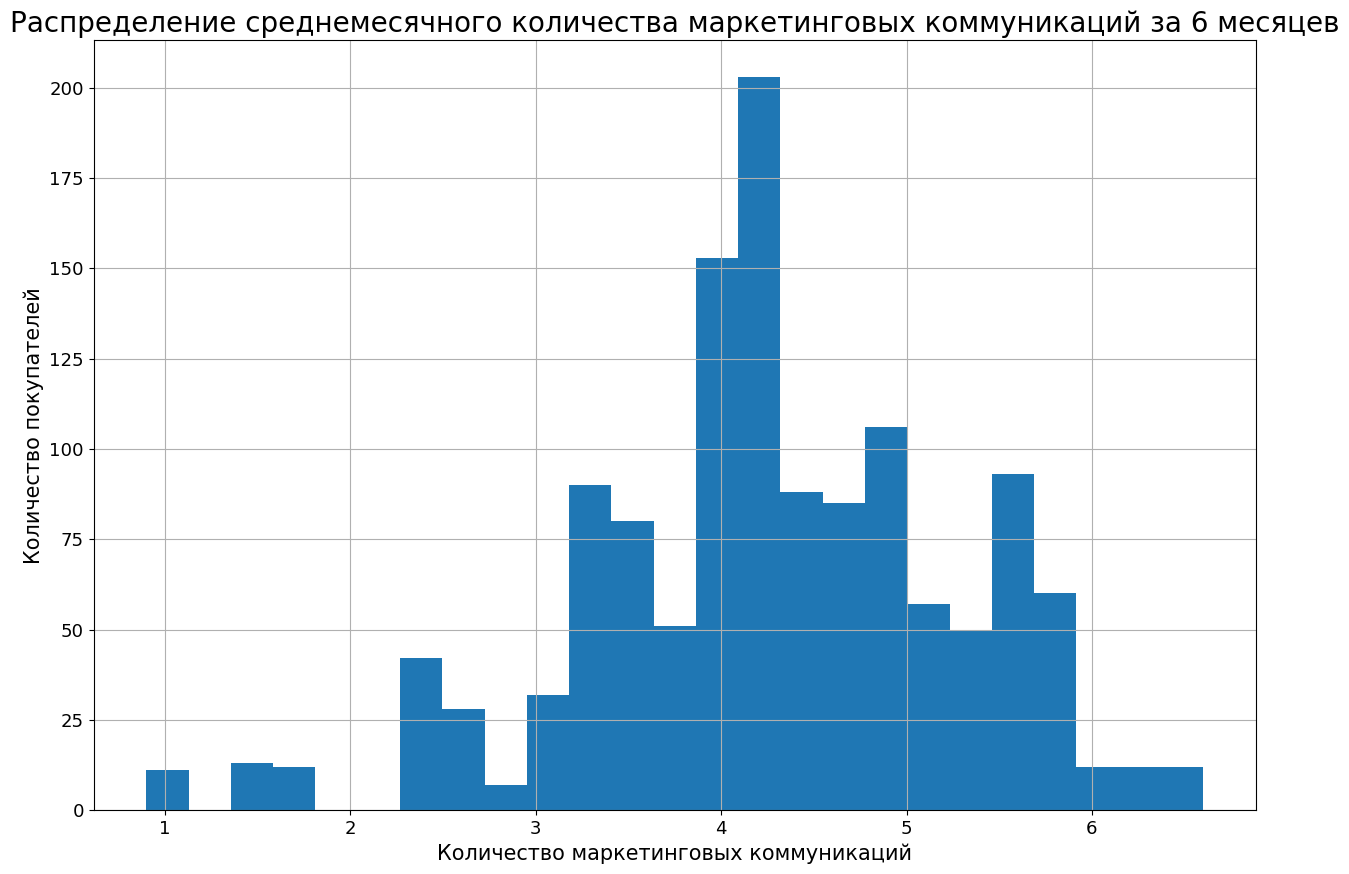

In [418]:
market_file['Маркет_актив_6_мес'].hist(bins=25, figsize=(15, 10))
plt.title('Распределение среднемесячного количества маркетинговых коммуникаций за 6 месяцев', size=20)
plt.xlabel('Количество маркетинговых коммуникаций', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

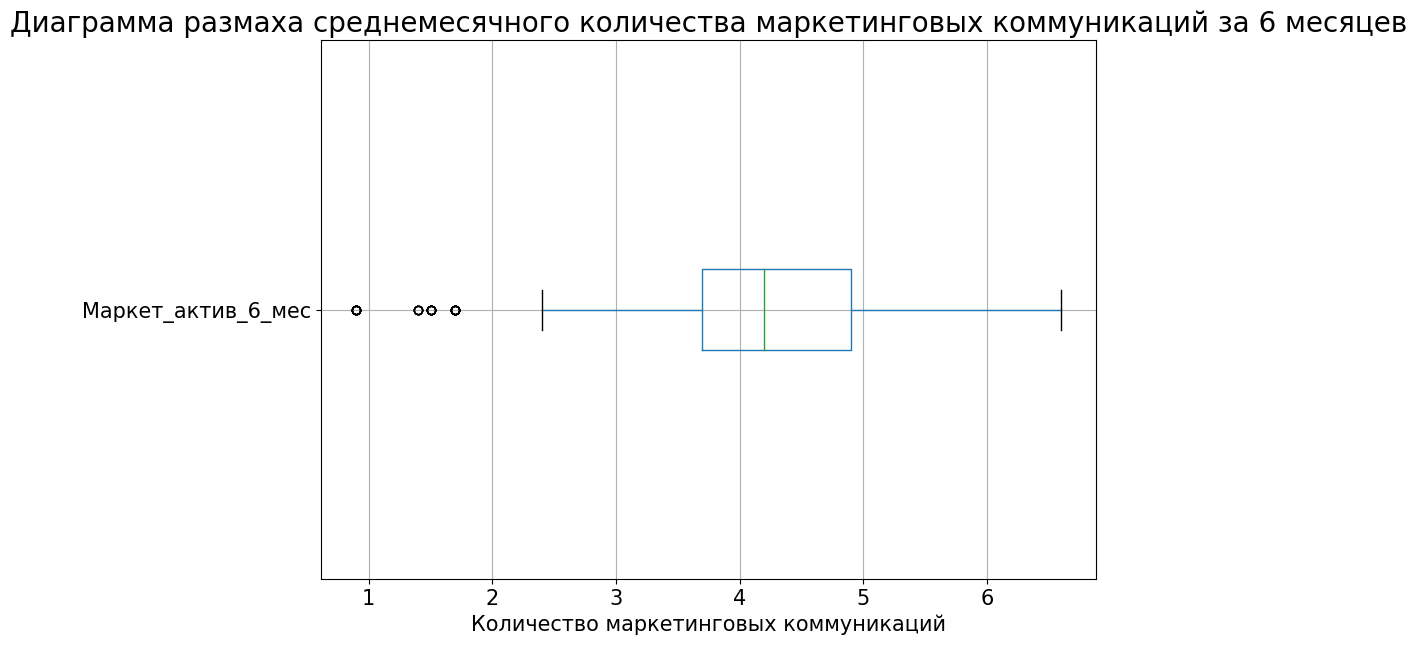

In [419]:
market_file.boxplot('Маркет_актив_6_мес', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха среднемесячного количества маркетинговых коммуникаций за 6 месяцев', size=20)
plt.xlabel('Количество маркетинговых коммуникаций', size=15)
market_file['Маркет_актив_6_мес'].describe()

Среднемесячное значение маркетинговых коммуникаций распределено со средним значением 4.2. По графикам видим, что есть 4 немного выбивающихся значения, но удалять их не будем, так как они могут иметь значение. Вполне возможно есть клиенты, с которыми нет большой необходимости часто проводить рекламные акции.

### Количество маркетинговых коммуникаций в текущем месяце.

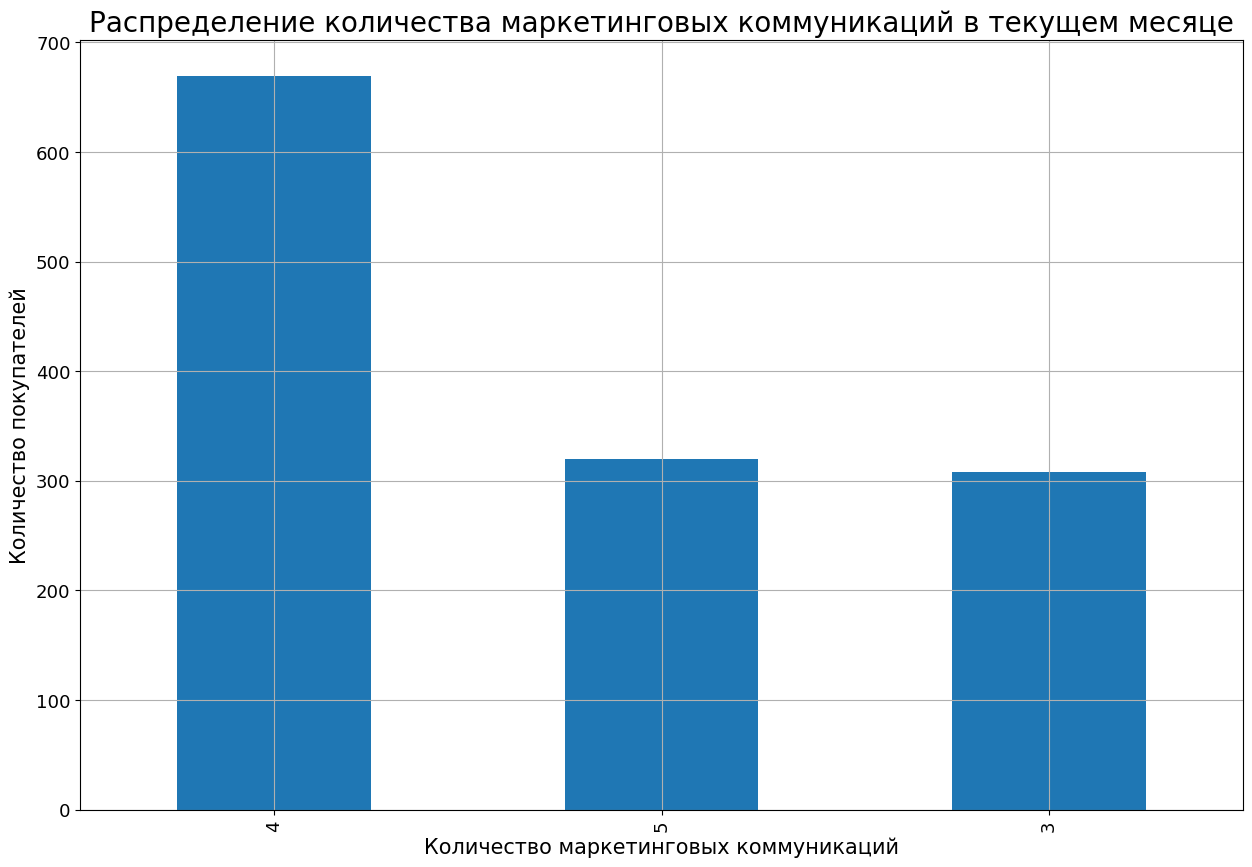

In [420]:
market_file['Маркет_актив_тек_мес'].value_counts().plot(kind='bar', figsize=(15, 10))
plt.title('Распределение количества маркетинговых коммуникаций в текущем месяце', size=20)
plt.xlabel('Количество маркетинговых коммуникаций', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.grid()
plt.show()

In [421]:
market_file['Маркет_актив_тек_мес'].value_counts()

Маркет_актив_тек_мес
4    669
5    320
3    308
Name: count, dtype: int64

Как можно заметить, в текущем месяце всего 3 значения количества маркетинговых коммуникаций с клиентом. Заметно выделяется (в 2 раза) значение 4, что как раз почти совпадает со средним среднемесячным значением предыдущего признака.

### Количество дней с момента регистрации покупателя на сайте.

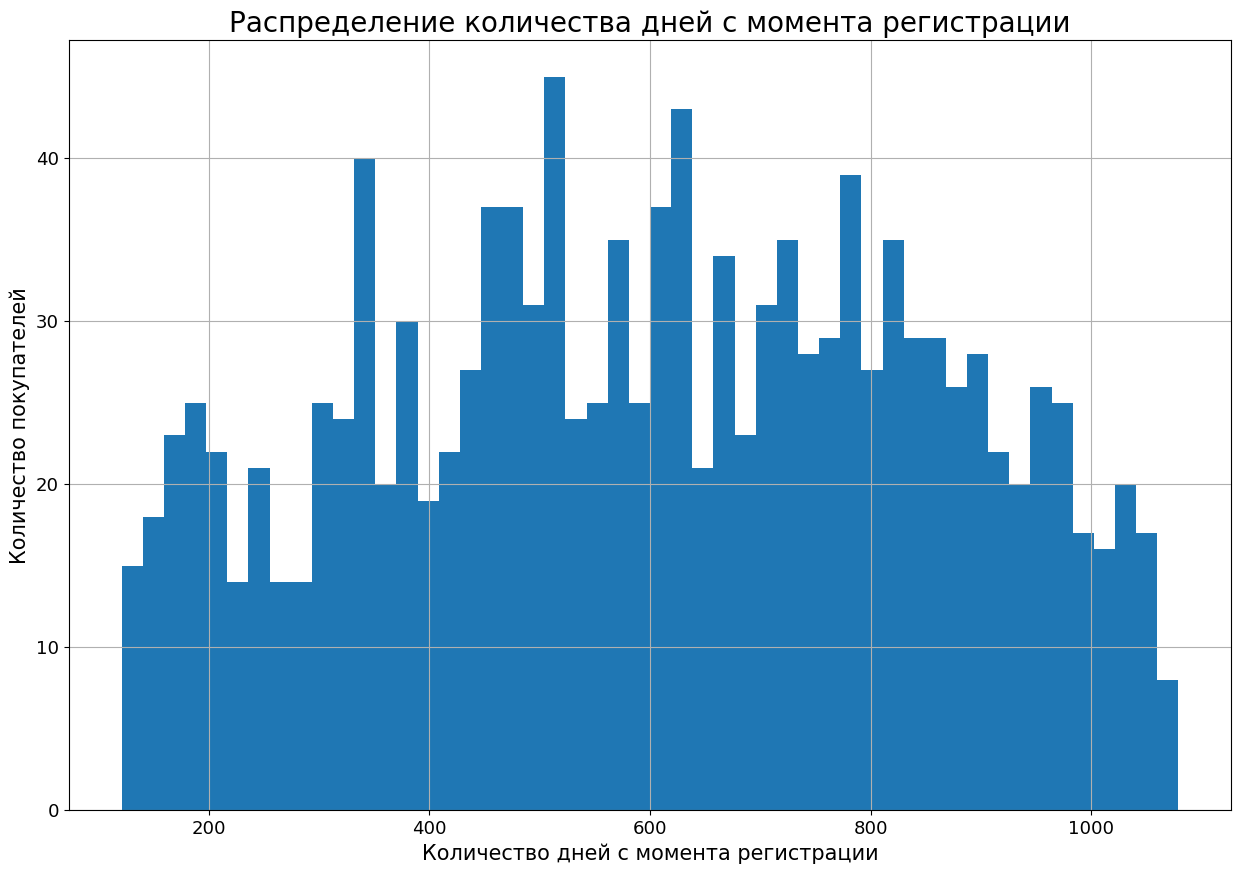

In [422]:
market_file['Длительность'].hist(bins=50, figsize=(15, 10))
plt.title('Распределение количества дней с момента регистрации', size=20)
plt.xlabel('Количество дней с момента регистрации', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

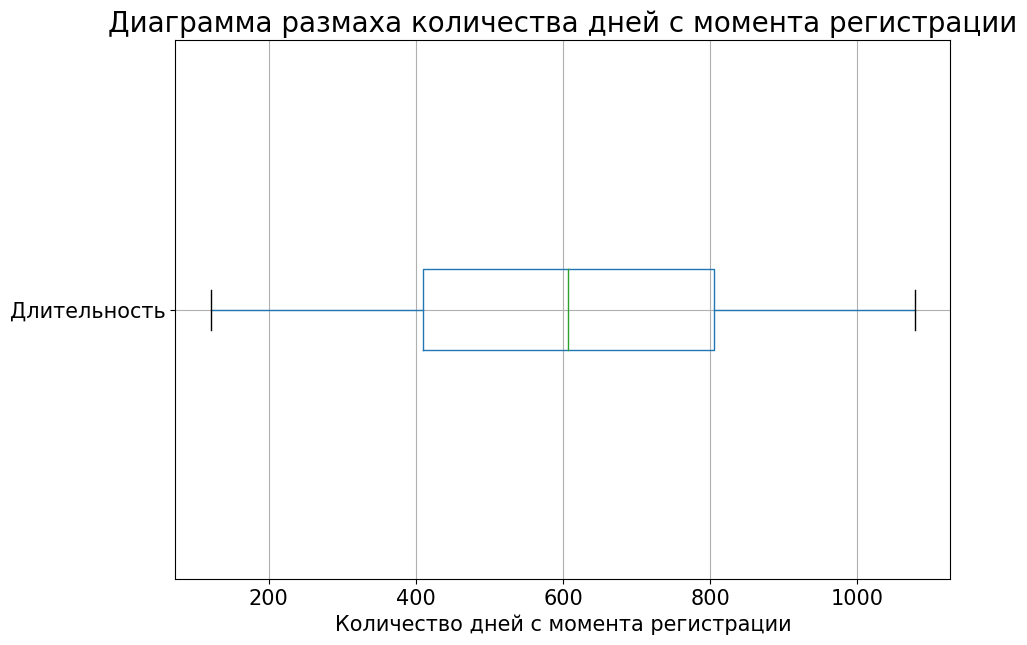

In [423]:
market_file.boxplot('Длительность', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха количества дней с момента регистрации', size=20)
plt.xlabel('Количество дней с момента регистрации', size=15)
market_file['Длительность'].describe()

Здесь имеем распределение с отсутствием выбросов и с почти совпадающими средним и медианным значениями (603 и 607). В представленной выборке 1079 дней (около 3 лет) - максимальное значение дней после региcтрации, 121 - минимальное.

### Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

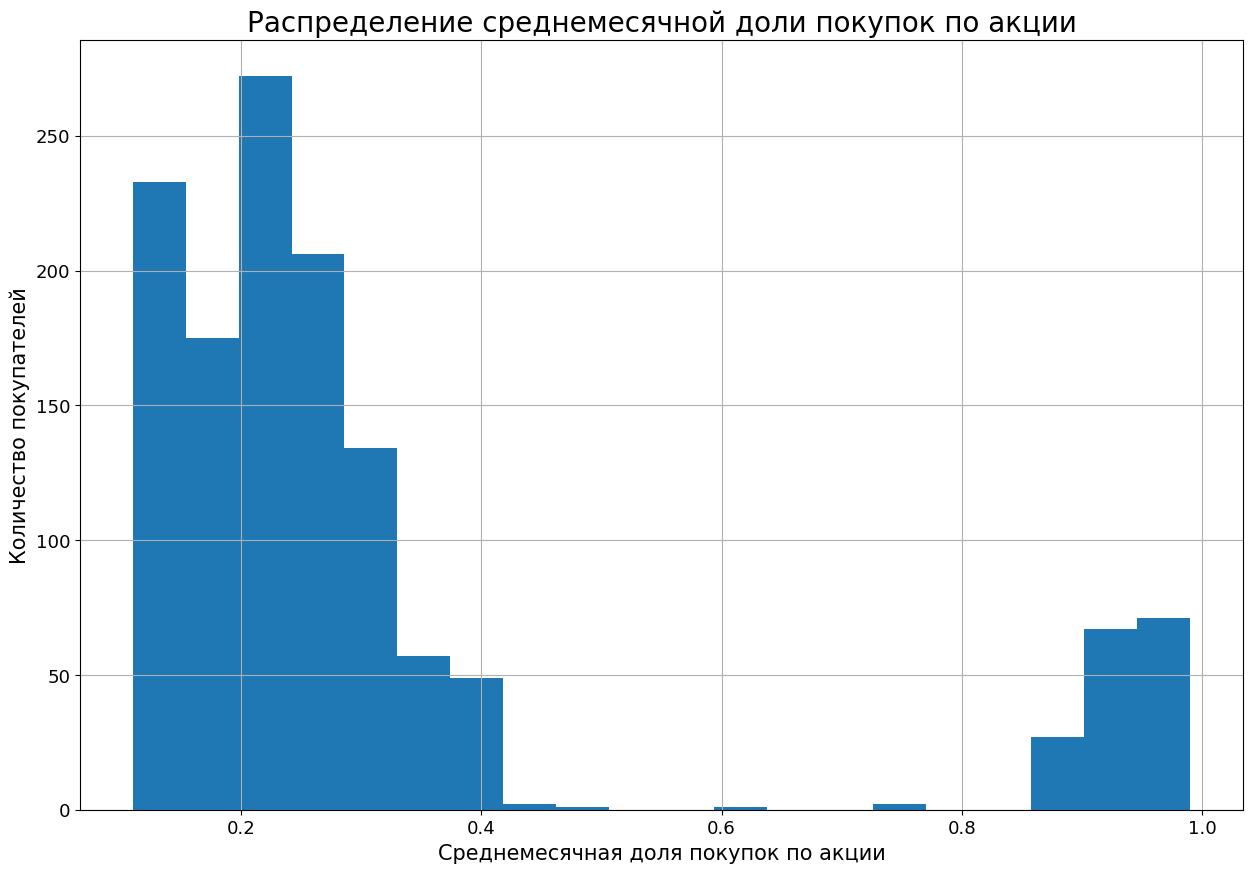

In [424]:
market_file['Акционные_покупки'].hist(bins=20, figsize=(15, 10))
plt.title('Распределение среднемесячной доли покупок по акции', size=20)
plt.xlabel('Среднемесячная доля покупок по акции', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

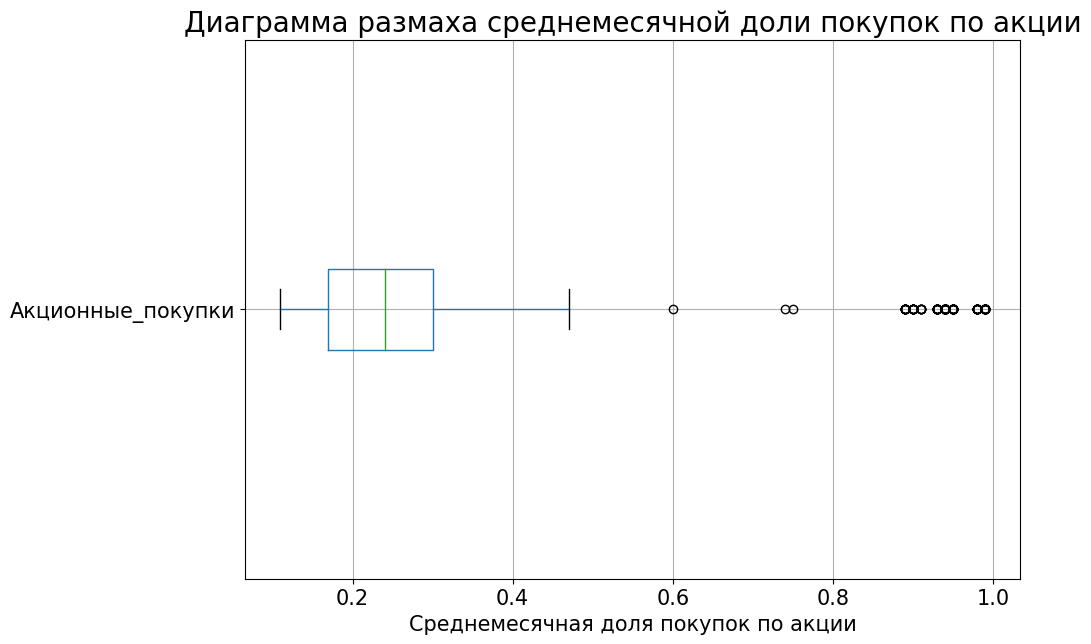

In [425]:
market_file.boxplot('Акционные_покупки', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха среднемесячной доли покупок по акции', size=20)
plt.xlabel('Среднемесячная доля покупок по акции', size=15)
market_file['Акционные_покупки'].describe()

Мы видим, что клиенты, совершающие большинство покупок по акции, скорее исключение из правила (но всё же есть небольшой пик таких клиентов с долей от 90 до 99%). Доля таких покупок у основной массы покупателей от 0.15 до 0.4. 

### Среднее количество просмотренных категорий за визит.

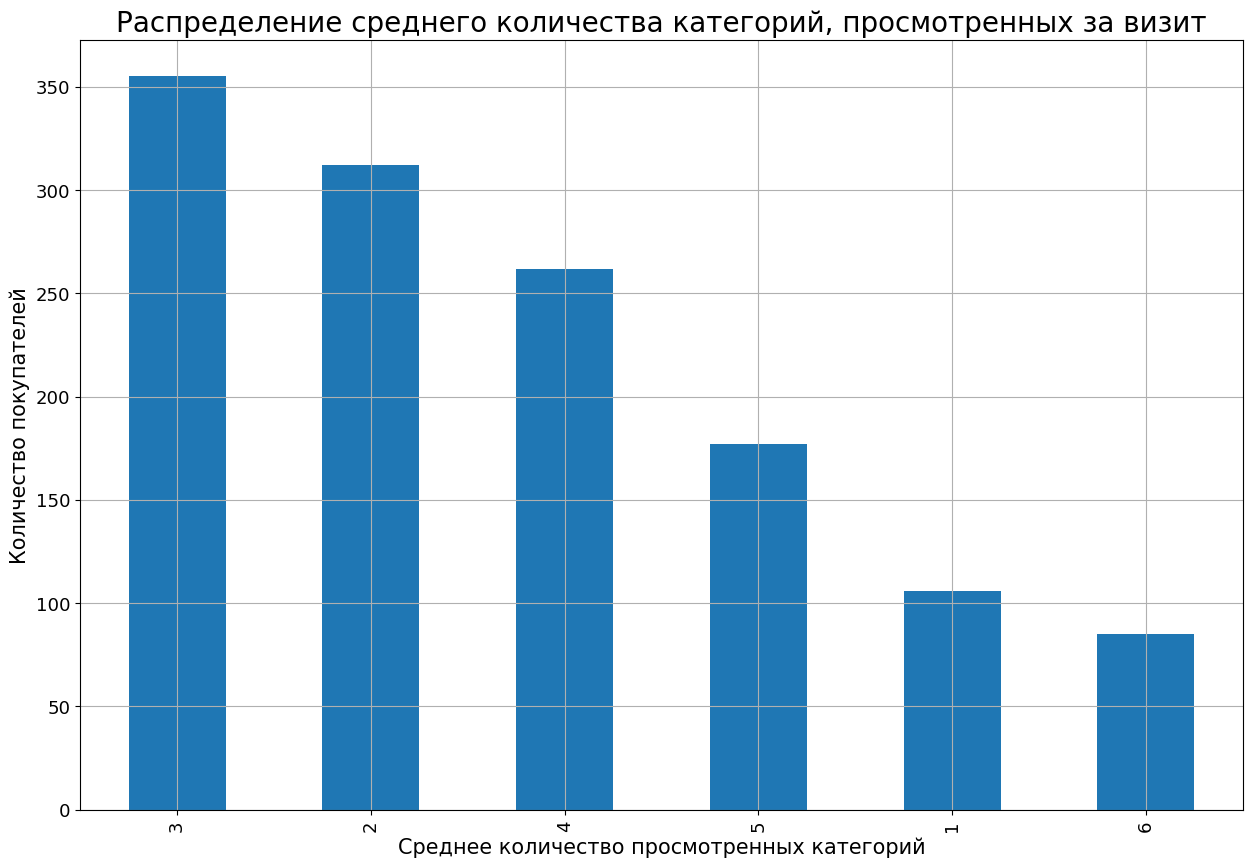

In [426]:
market_file['Средний_просмотр_категорий_за_визит'].value_counts().plot(kind='bar', figsize=(15, 10))
plt.title('Распределение среднего количества категорий, просмотренных за визит', size=20)
plt.xlabel('Среднее количество просмотренных категорий', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.grid()
plt.show()

В данном случае совсем малое количество значений, поэтому лучше подойдёт столбчатая диаграмма. Наиболее часто встречаются значения от 2 до 4 просмотренных категорий.

### Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

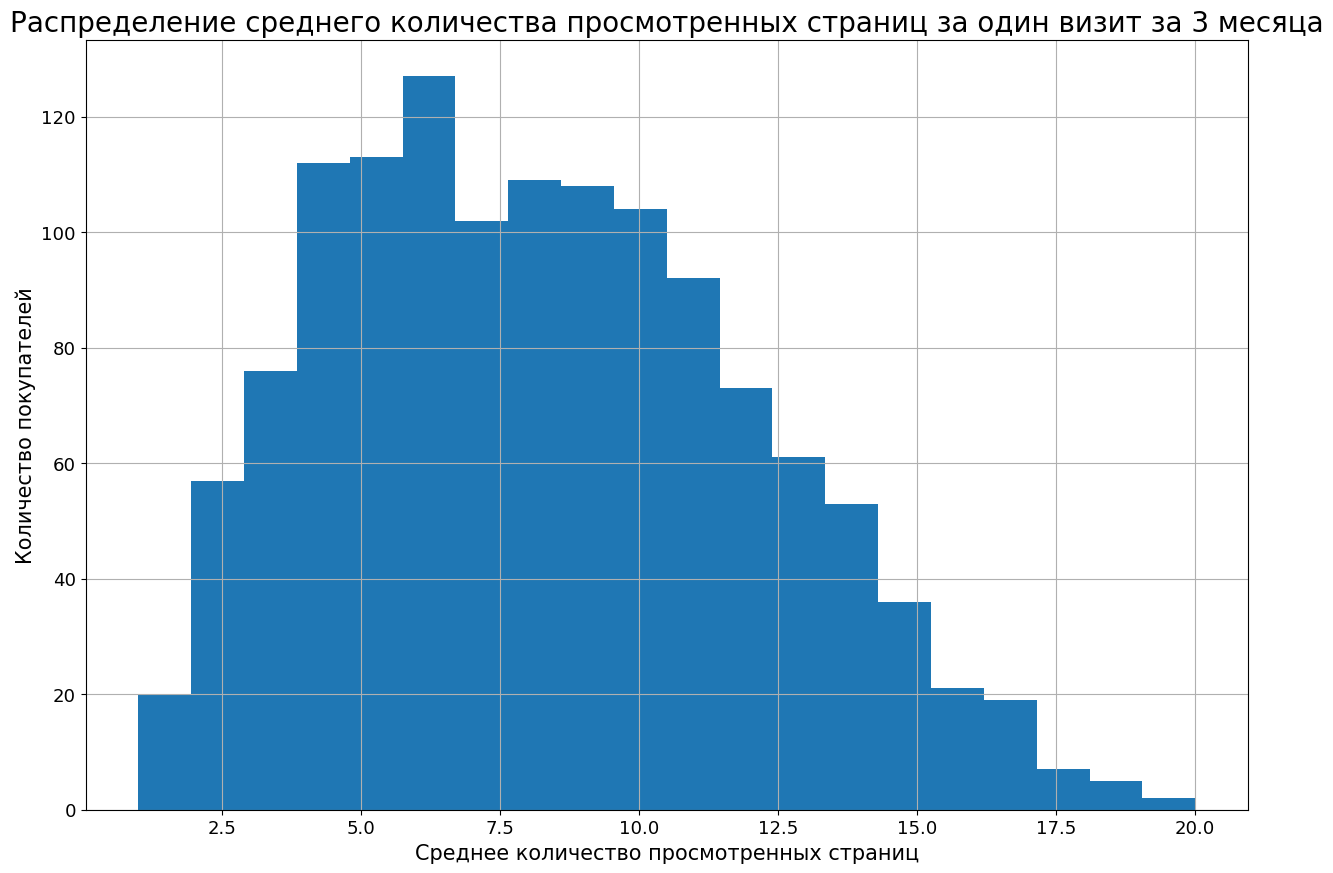

In [427]:
market_file['Страниц_за_визит'].hist(bins=20, figsize=(15, 10))
plt.title('Распределение среднего количества просмотренных страниц за один визит за 3 месяца', size=20)
plt.xlabel('Среднее количество просмотренных страниц', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

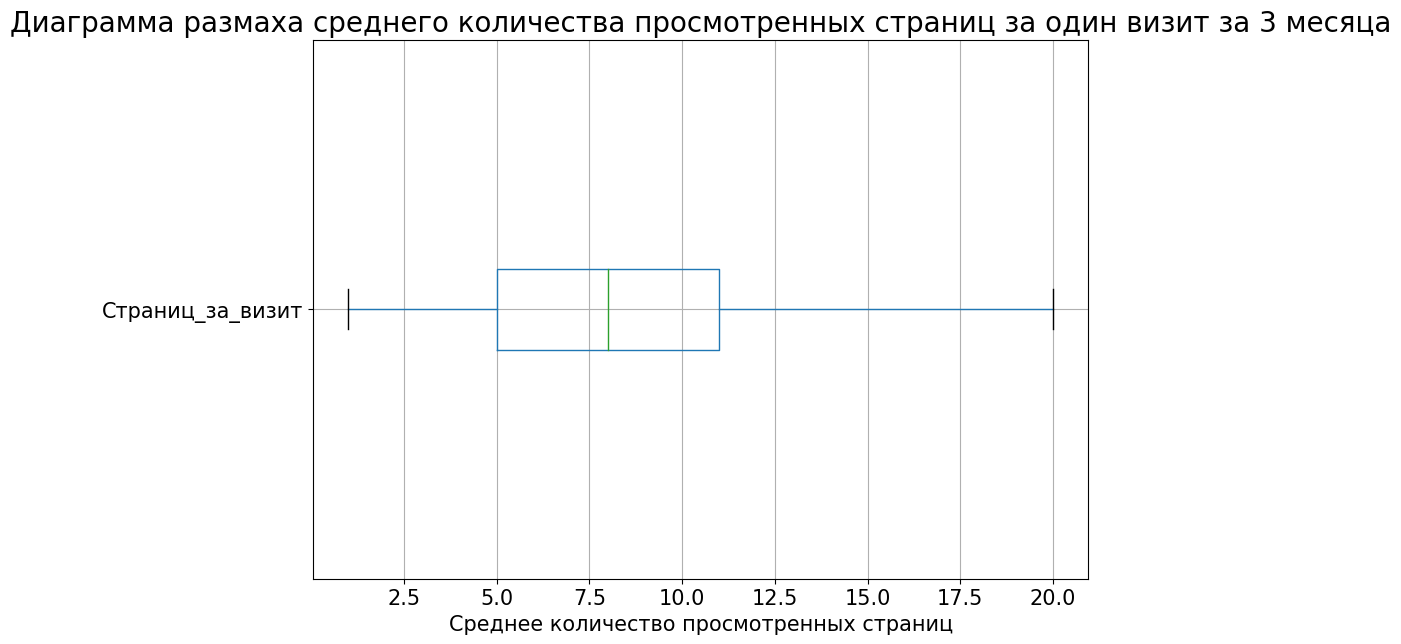

In [428]:
market_file.boxplot('Страниц_за_визит', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха среднего количества просмотренных страниц за один визит за 3 месяца', size=20)
plt.xlabel('Среднее количество просмотренных страниц', size=15)
market_file['Страниц_за_визит'].describe()

Наблюдаем распределение со средним и медианным значением 8 просмотренных страниц за один визит.

### Общее число неоплаченных товаров в корзине за последние 3 месяца.

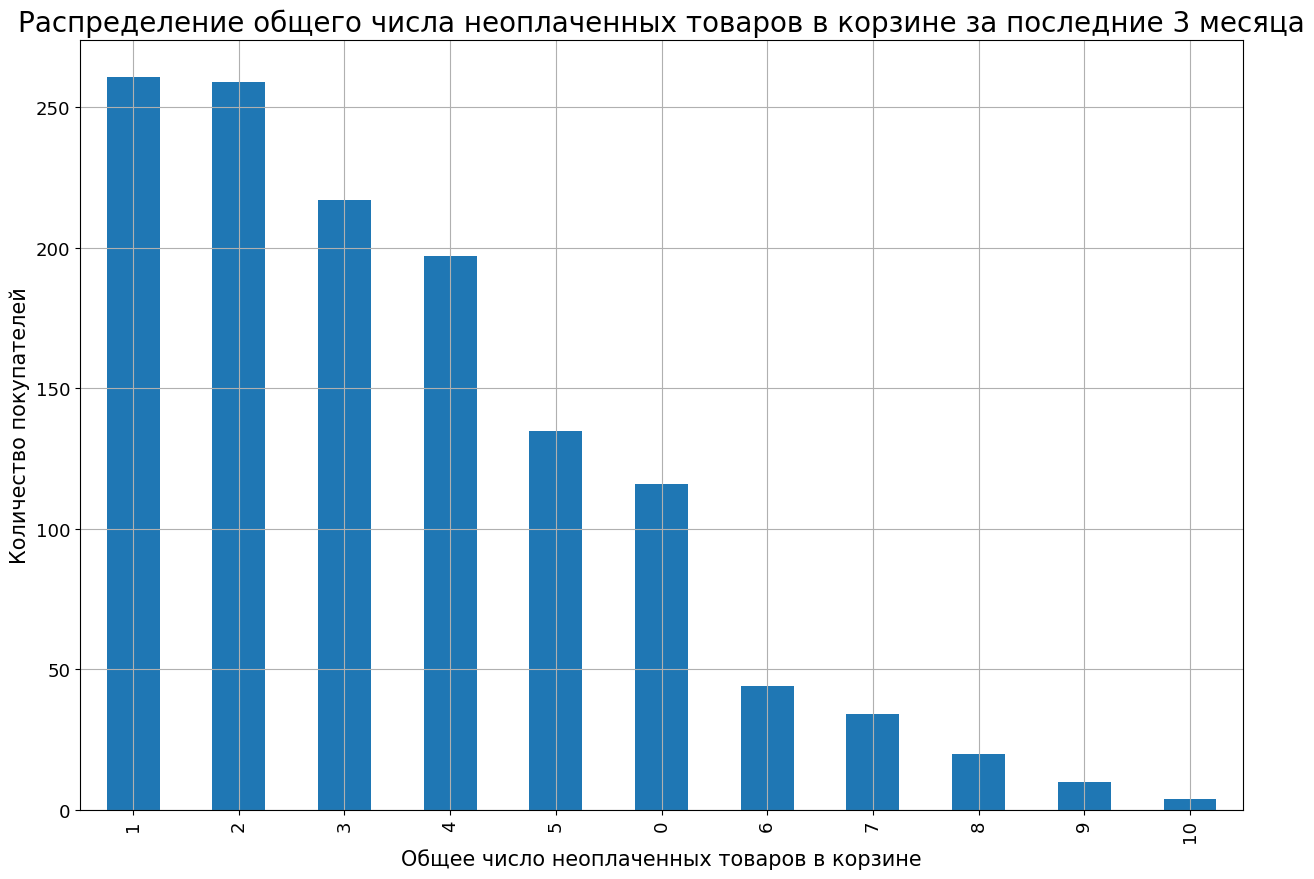

In [429]:
market_file['Неоплаченные_продукты_штук_квартал'].value_counts().plot(kind='bar', figsize=(15, 10))
plt.title('Распределение общего числа неоплаченных товаров в корзине за последние 3 месяца', size=20)
plt.xlabel('Общее число неоплаченных товаров в корзине', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.grid()
plt.show()

Количество покупателей снижается по мере возрастания количества неоплаченных товаров корзине. Отдельно стоит отметить коло 120 клиентов, у которых вообще никогда не было в корзине неоплаченных товаров.

### Число сбоев, которые коснулись покупателя во время посещения сайта.

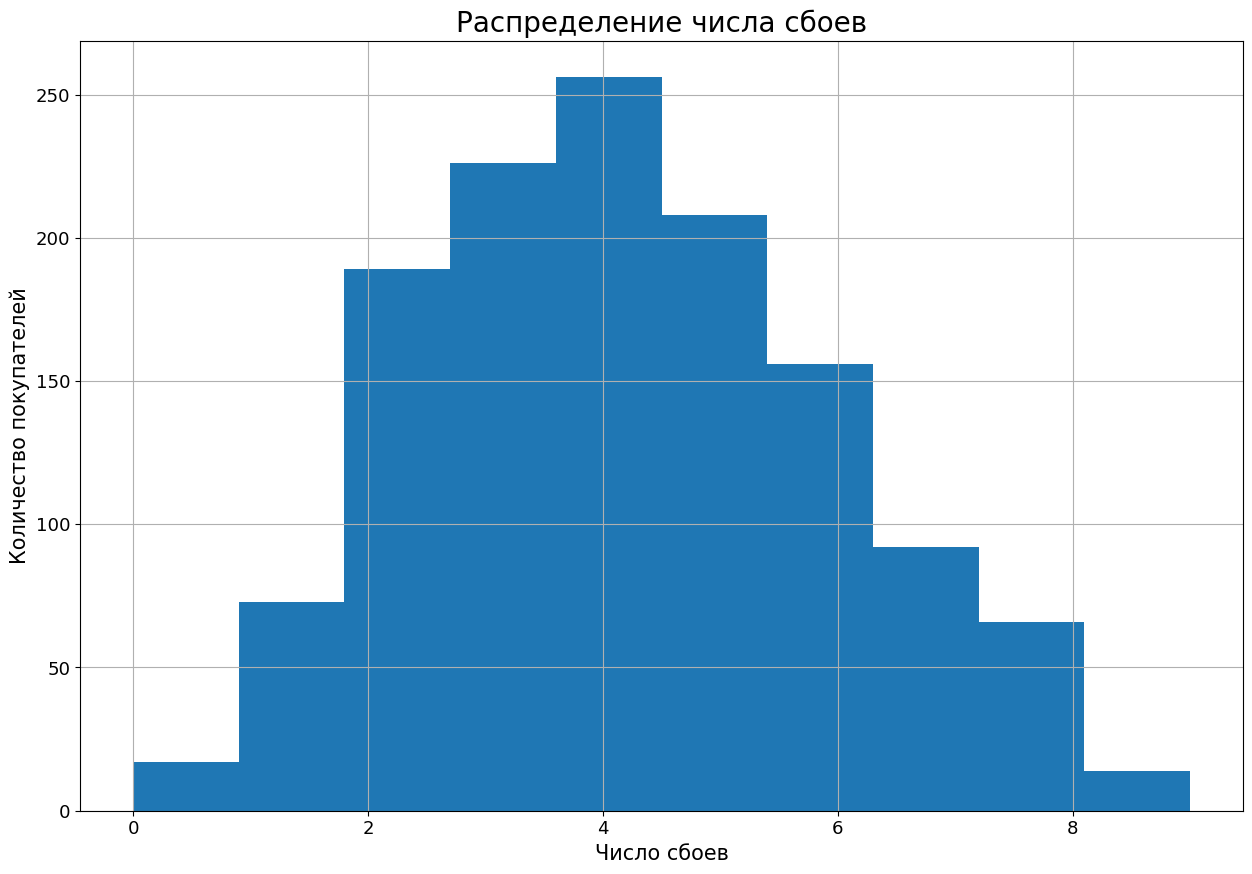

In [430]:
market_file['Ошибка_сервиса'].hist(bins=10, figsize=(15, 10))
plt.title('Распределение числа сбоев', size=20)
plt.xlabel('Число сбоев', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

Значение числа сбоев нормально распределено от 0 до 9 со средним 4.

### Уровень сервиса.

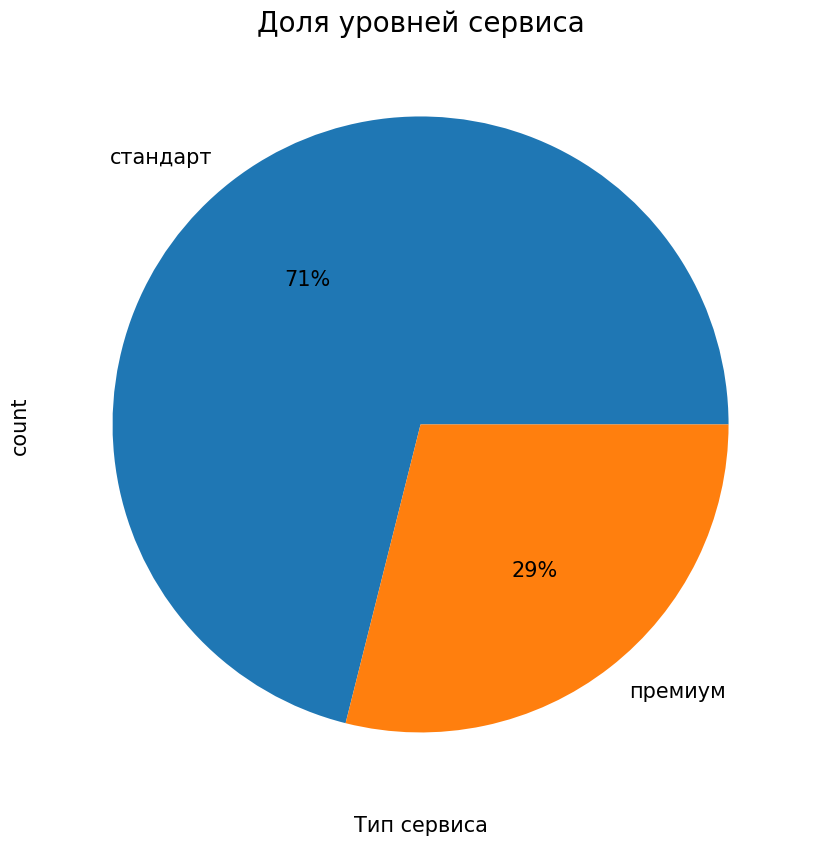

In [431]:
market_file['Тип_сервиса'].value_counts().plot(kind='pie', subplots=True, figsize=[15, 10], autopct='%.0f%%')
plt.title('Доля уровней сервиса', size=20)
plt.xlabel('Тип сервиса', size=15)
plt.rc('font', size= 15)
plt.show()

Доля клиентов с премиальным сервисом составляет 29% от общего числа.

### Самая популярная категория товаров у покупателя за последние 6 месяцев.

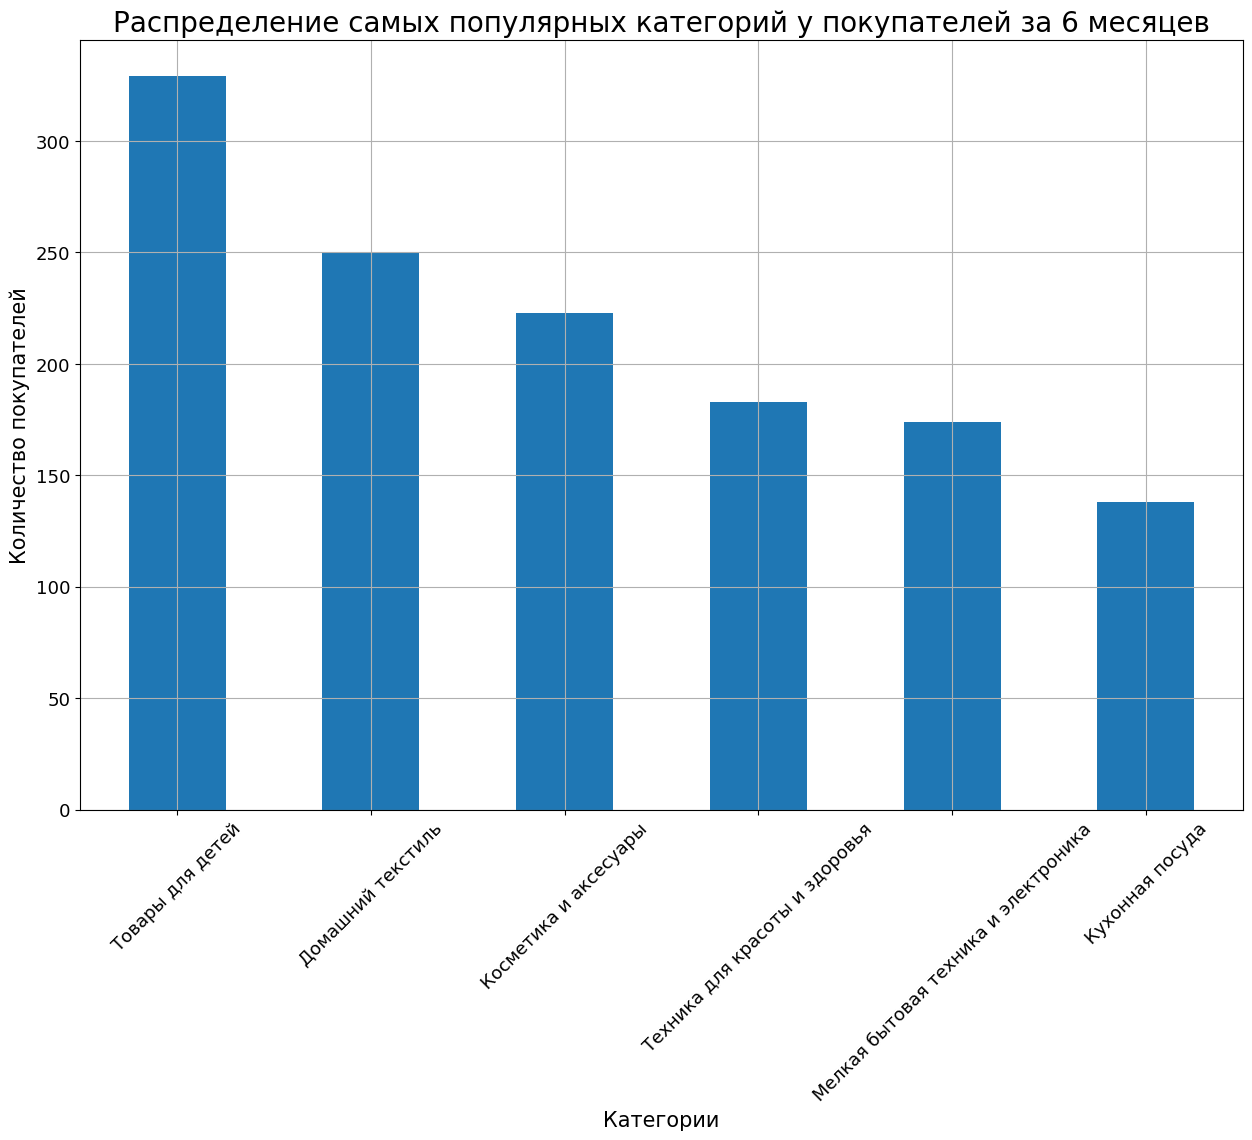

In [432]:
market_file['Популярная_категория'].value_counts().plot(kind='bar', figsize=(15, 10))
plt.title('Распределение самых популярных категорий у покупателей за 6 месяцев', size=20)
plt.xlabel('Категории', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13, rotation=45)
plt.yticks(size = 13)
plt.grid()
plt.show()

За последние 6 месяцев самой популярной категорией у покупателей оказалась "Товары для детей", а самой непопулярной - "Кухонная посуда".

### Информация о том, можно ли присылать покупателю дополнительные предложения о товаре.

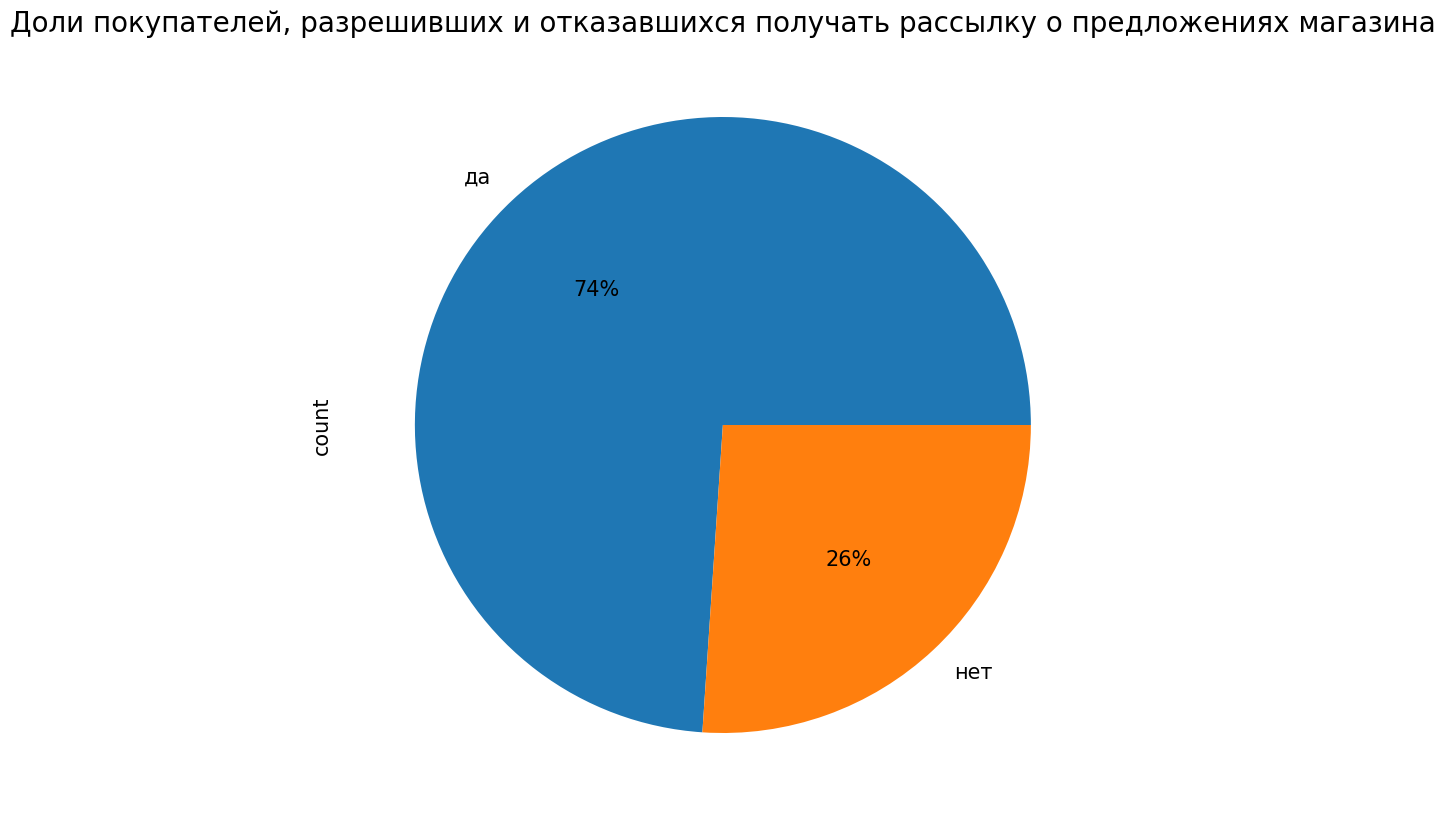

In [433]:
market_file['Разрешить_сообщать'].value_counts().plot(kind='pie', subplots=True, figsize=[15, 10], autopct='%.0f%%')
plt.title('Доли покупателей, разрешивших и отказавшихся получать рассылку о предложениях магазина', size=20)
plt.rc('font', size= 15)
plt.show()

74% покупателей из выборки дали согласие получать дполнительные предложения о покупке товаров.

### Данные о выручке, которую получает магазин с покупателя за период взаимодействия.

Чтобы можно было проанализировать данные по выручке по месяцам, нужно видоизменить таблицу market_money так, чтобы в ней стало 4 столбца: id и отдельно 3 месяца.

In [434]:
market_money = pd.pivot_table(market_money, index='id', columns='Период', values='Выручка')
market_money.head()  # Проверим результат

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [435]:
market_money.info() # Проверим количество строк

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   предыдущий_месяц     1297 non-null   float64
 1   препредыдущий_месяц  1297 non-null   float64
 2   текущий_месяц        1297 non-null   float64
dtypes: float64(3)
memory usage: 40.5 KB


Теперь строчек ровно столько, сколько и в основном датафрейме (1297). Проведём анализ выручки по каждому месяцу.

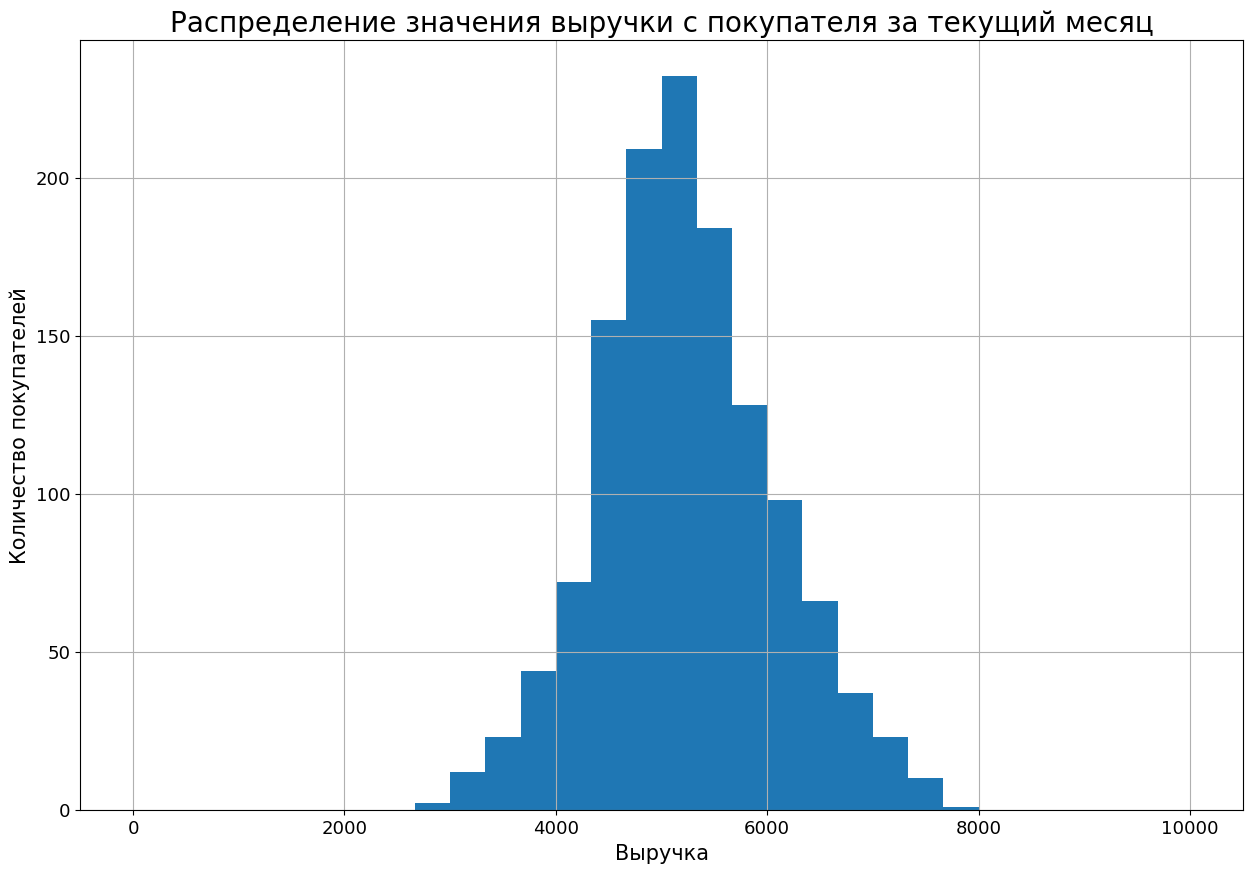

In [436]:
market_money['текущий_месяц'].hist(bins=30, range=(0, 10000), figsize=(15, 10))
plt.title('Распределение значения выручки с покупателя за текущий месяц', size=20)
plt.xlabel('Выручка', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count      1297.000000
mean       5316.449268
std        2942.469139
min        2758.700000
25%        4706.600000
50%        5180.300000
75%        5761.300000
max      106862.200000
Name: текущий_месяц, dtype: float64

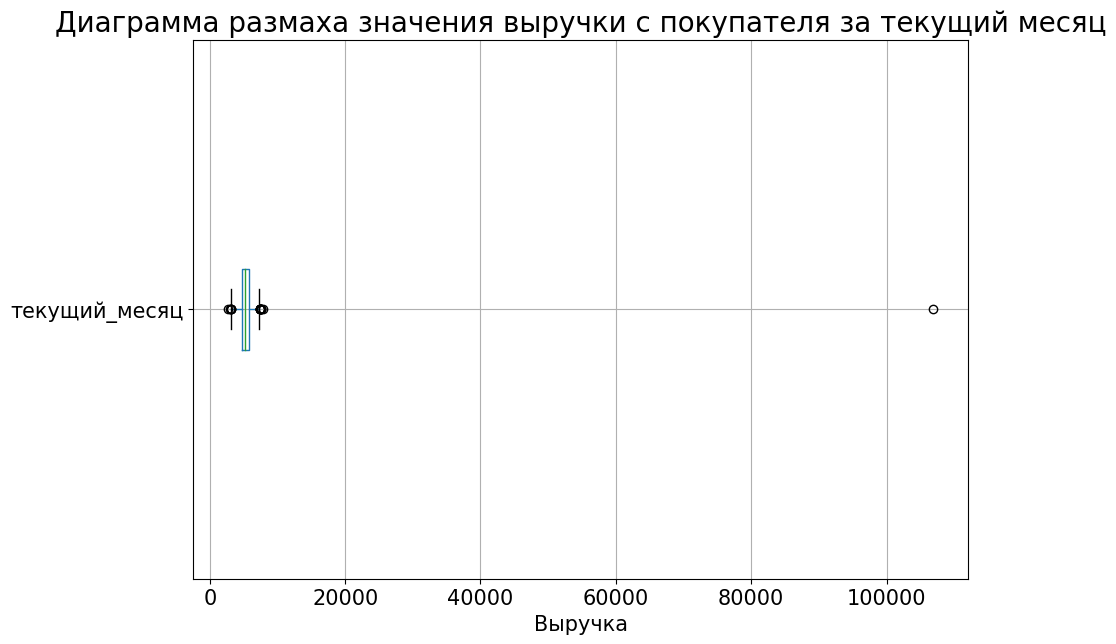

In [437]:
market_money.boxplot('текущий_месяц', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха значения выручки с покупателя за текущий месяц', size=20)
plt.xlabel('Выручка', size=15)
market_money['текущий_месяц'].describe()

In [438]:
print(market_money[market_money['текущий_месяц'] > 100000])

Период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                          
215380            6077.0               5051.0       106862.2


В выручке за текущий месяц есть очевидный выброс - значение резко выделяющееся на фоне остальных. Покупатель с id 215380 совершил покупок в текущем месяце на 106862, тогда как остальные все значения распределены от 2700 до 8000. Очевидно, что такое значение будет искажать общую картину. Поэтому есть 2 варината, как поступить в данном случае: удалить строчку с этим id либо заменить это значение на среднее за 2 предыдущих месяца этого же клиента (тем более, что они как раз совсем не выбиваются из общей массы). Выберем последнее. 

In [439]:
market_money.at[215380, 'текущий_месяц'] = (6077+5051)/2

count    1297.000000
mean     5238.347340
std       834.045867
min      2758.700000
25%      4706.600000
50%      5180.300000
75%      5758.600000
max      7799.400000
Name: текущий_месяц, dtype: float64

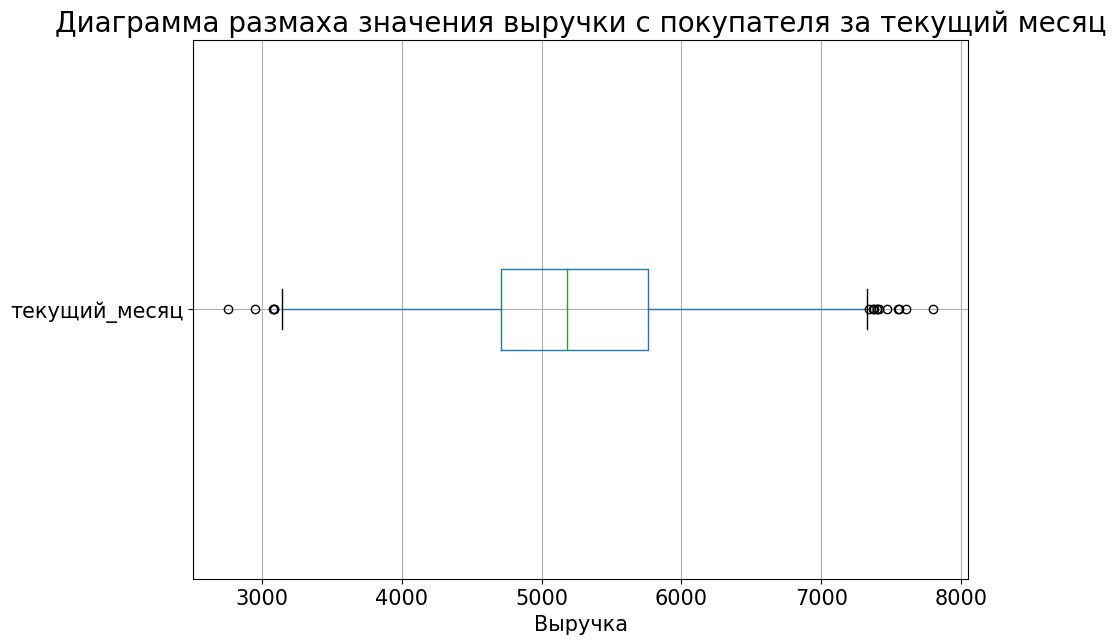

In [440]:
market_money.boxplot('текущий_месяц', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха значения выручки с покупателя за текущий месяц', size=20)
plt.xlabel('Выручка', size=15)
market_money['текущий_месяц'].describe()

Как мы видим, значение заменилось. Среднее уменьшилось, а вот медиана осталась на прежнем уровне, так как не чувствительна к выбросам.

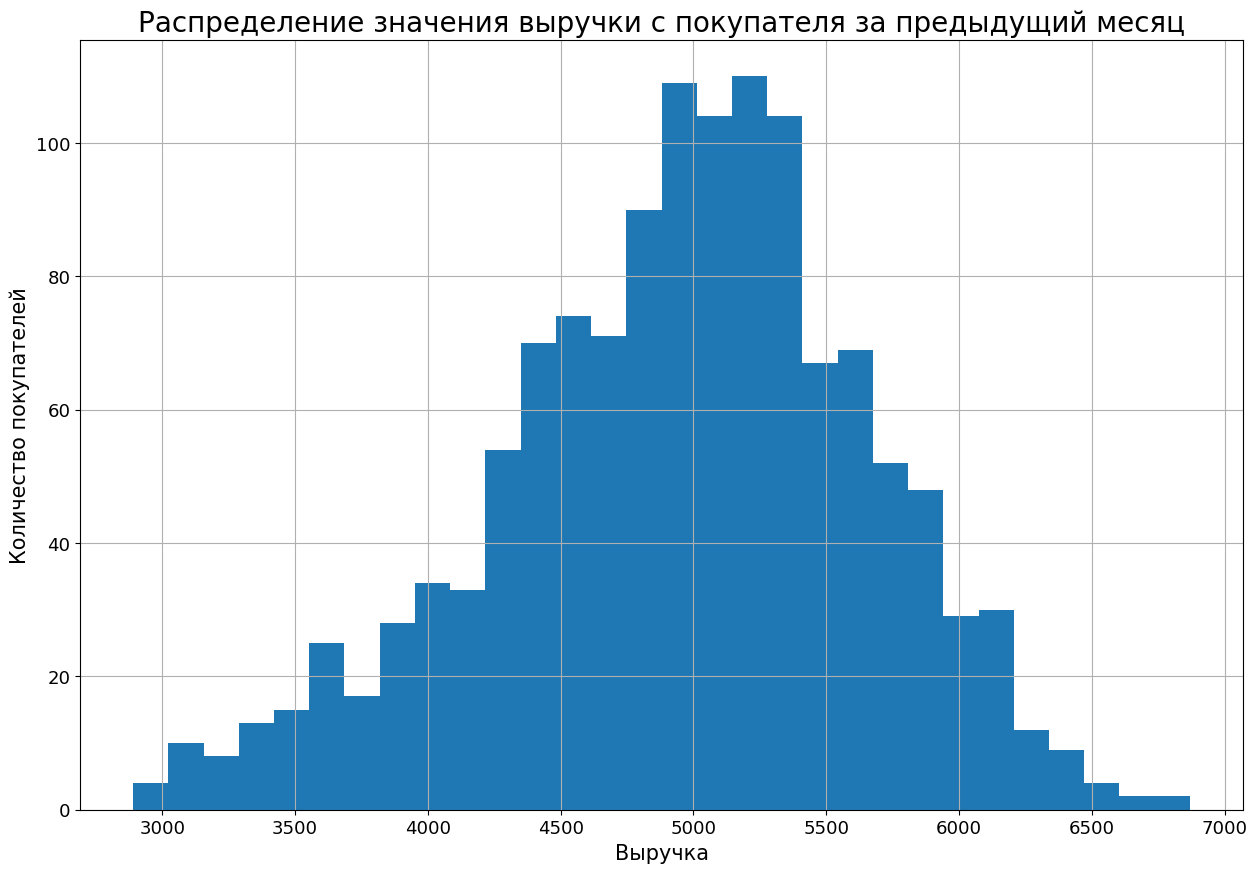

In [441]:
market_money['предыдущий_месяц'].hist(bins=30, figsize=(15, 10))
plt.title('Распределение значения выручки с покупателя за предыдущий месяц', size=20)
plt.xlabel('Выручка', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean     4948.339630
std       701.228571
min      2890.000000
25%      4498.500000
50%      5005.500000
75%      5409.000000
max      6869.500000
Name: предыдущий_месяц, dtype: float64

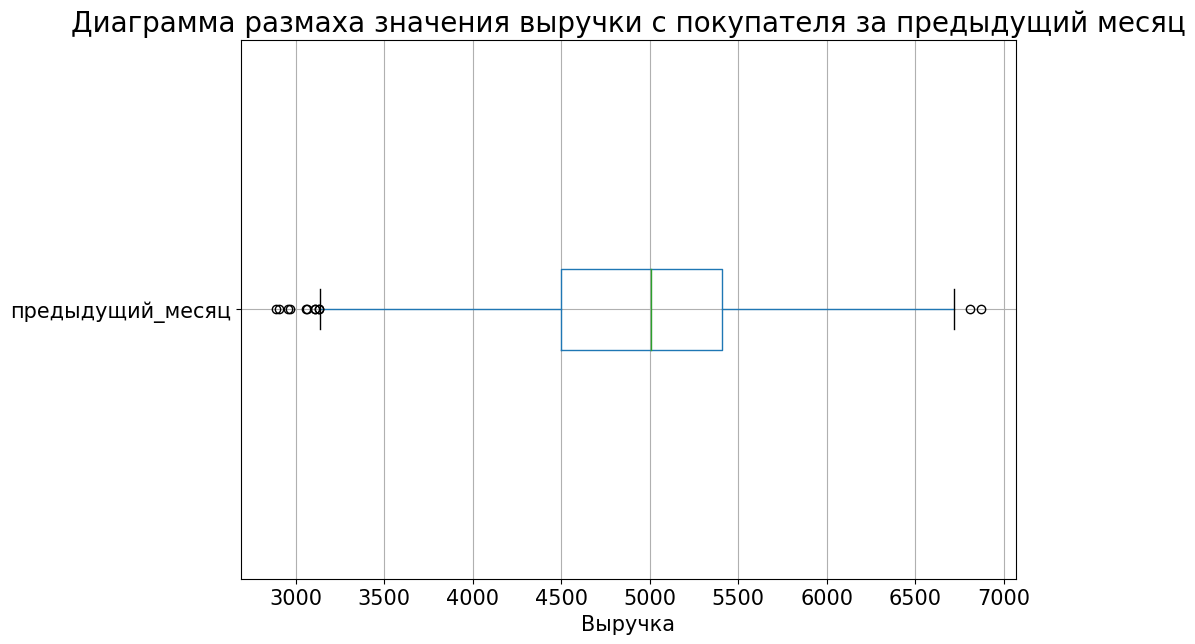

In [442]:
market_money.boxplot('предыдущий_месяц', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха значения выручки с покупателя за предыдущий месяц', size=20)
plt.xlabel('Выручка', size=15)
market_money['предыдущий_месяц'].describe()

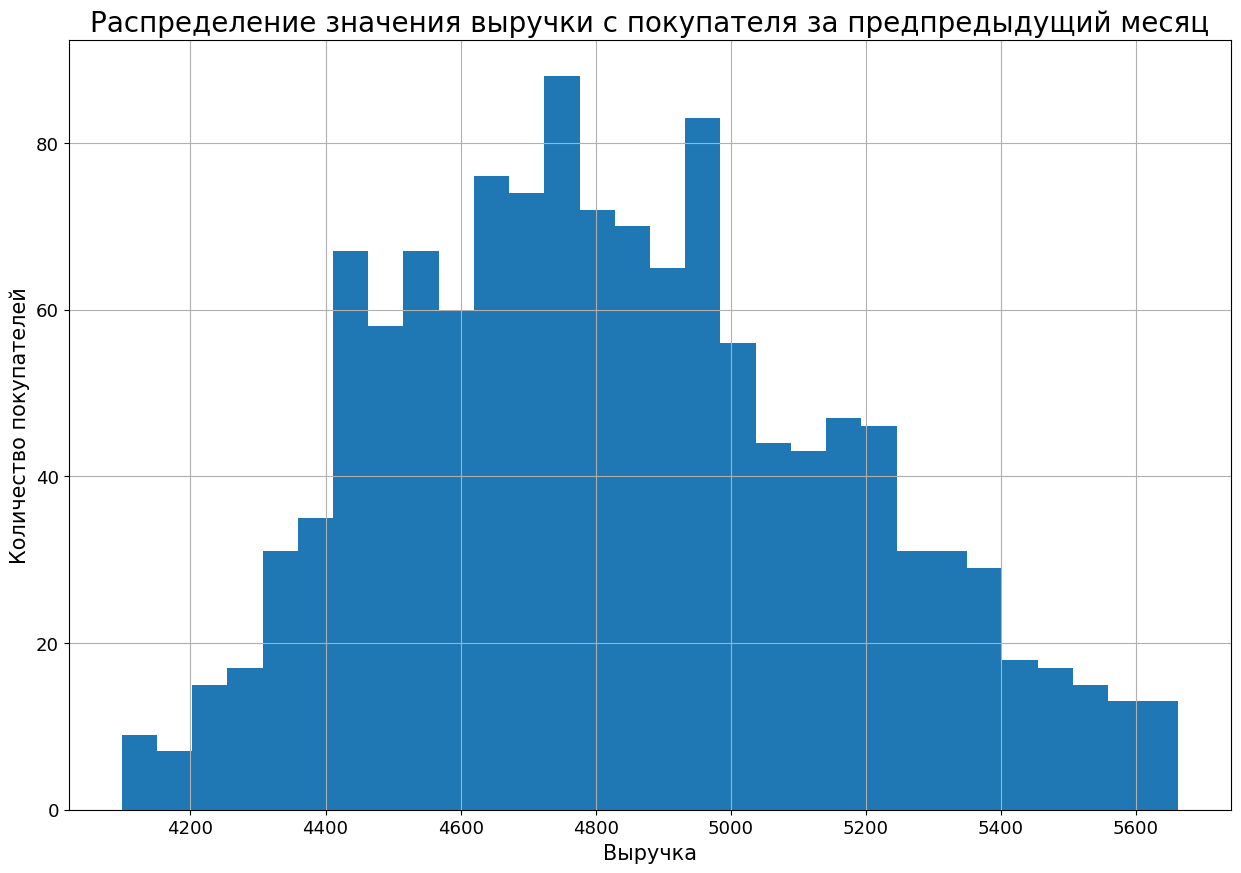

In [443]:
market_money['препредыдущий_месяц'].hist(bins=30, figsize=(15, 10))
plt.title('Распределение значения выручки с покупателя за предпредыдущий месяц', size=20)
plt.xlabel('Выручка', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: препредыдущий_месяц, dtype: float64

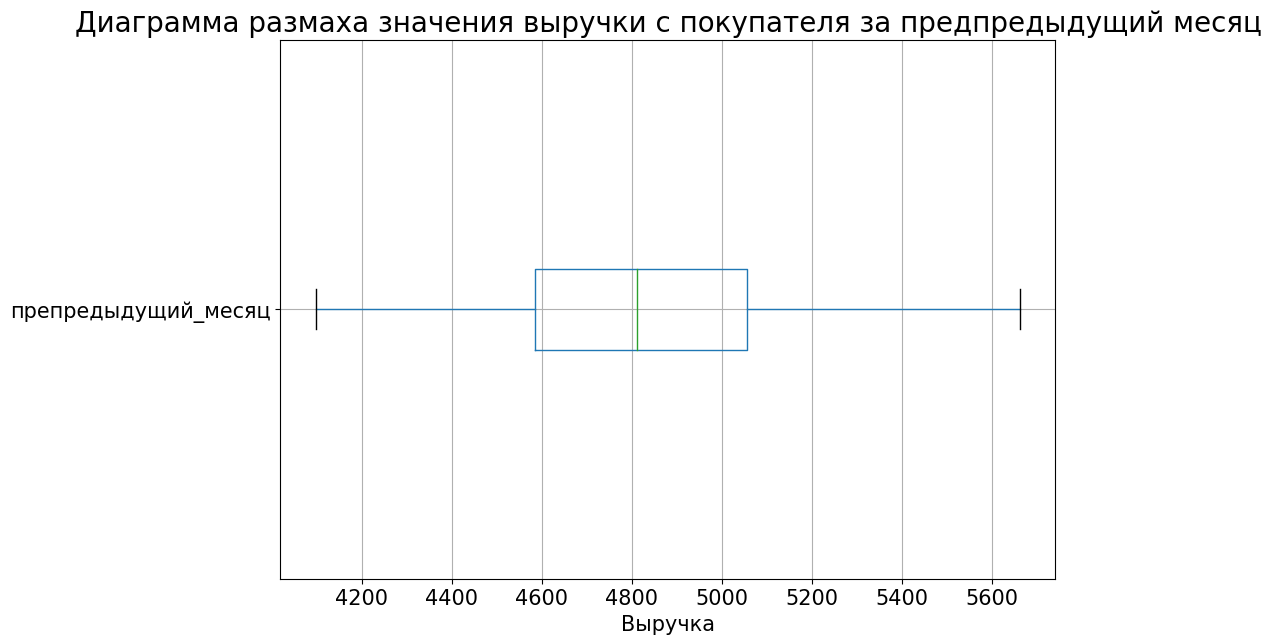

In [444]:
market_money.boxplot('препредыдущий_месяц', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха значения выручки с покупателя за предпредыдущий месяц', size=20)
plt.xlabel('Выручка', size=15)
market_money['препредыдущий_месяц'].describe()

По остальным месяцам всё в пределах нормы, аномальных значений не присутствует.

### Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Аналогично предыдущему пункту изменим таблицу со временем, проведённым покупателем на сайте.

In [445]:
market_time = pd.pivot_table(market_time, index='id', columns='Период', values='минут')
market_time.head()  # Проверим результат

Период,предыдущий_месяц,текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


In [446]:
market_time.info() # Проверим количество строк

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   предыдущий_месяц  1297 non-null   int64
 1   текущий_месяц     1297 non-null   int64
dtypes: int64(2)
memory usage: 30.4 KB


Всё в порядке. Получились те же 1297 строчек.

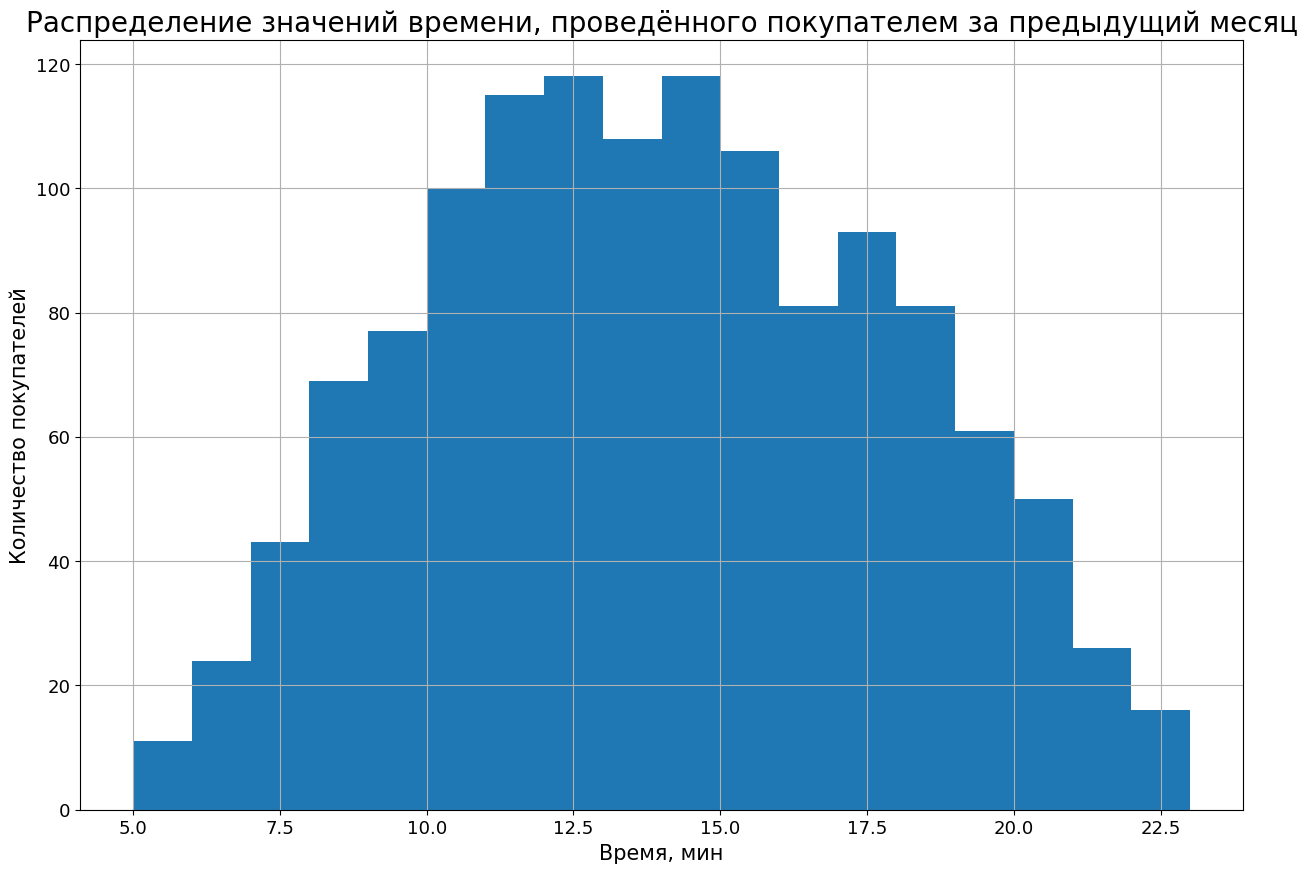

In [447]:
market_time['предыдущий_месяц'].hist(bins=18, figsize=(15, 10))
plt.title('Распределение значений времени, проведённого покупателем за предыдущий месяц', size=20)
plt.xlabel('Время, мин', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean       13.469545
std         3.936323
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: предыдущий_месяц, dtype: float64

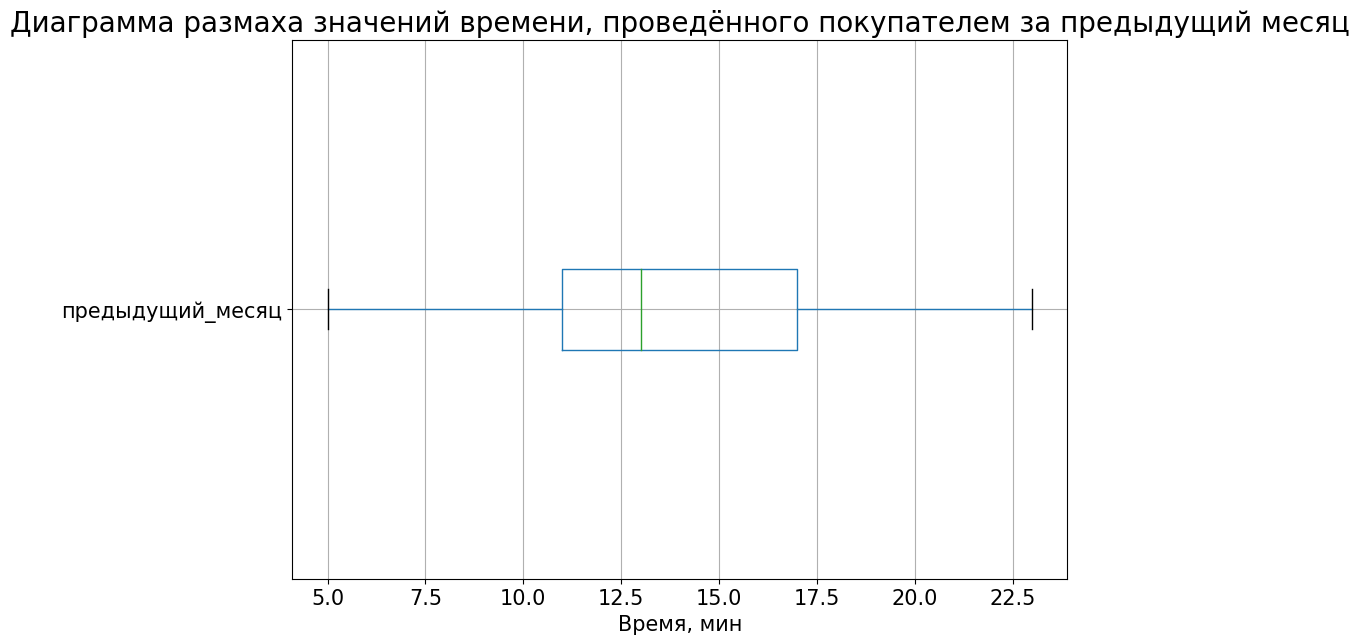

In [448]:
market_time.boxplot('предыдущий_месяц', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха значений времени, проведённого покупателем за предыдущий месяц', size=20)
plt.xlabel('Время, мин', size=15)
market_time['предыдущий_месяц'].describe()

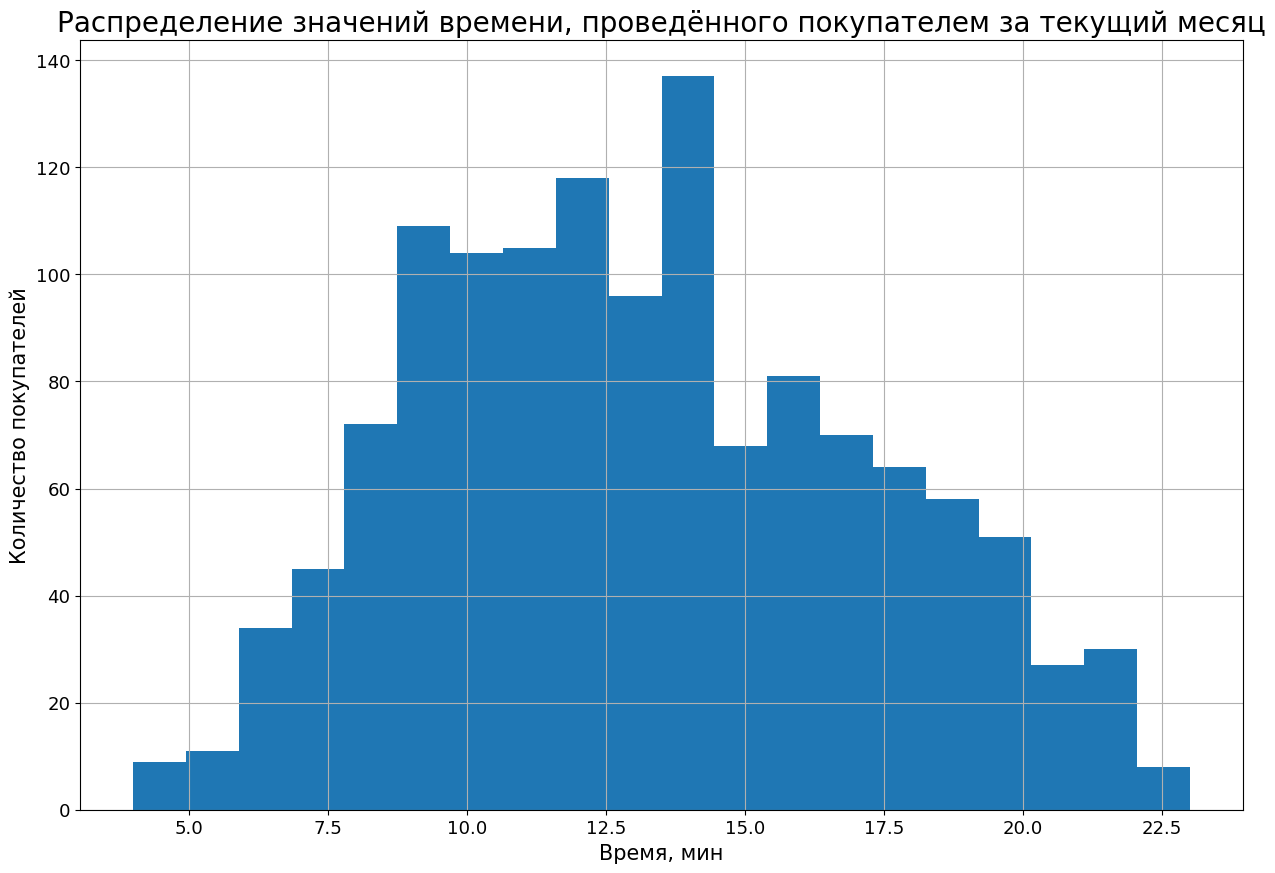

In [449]:
market_time['текущий_месяц'].hist(bins=20, figsize=(15, 10))
plt.title('Распределение значений времени, проведённого покупателем за текущий месяц', size=20)
plt.xlabel('Время, мин', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

count    1297.000000
mean       13.211257
std         4.220222
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: текущий_месяц, dtype: float64

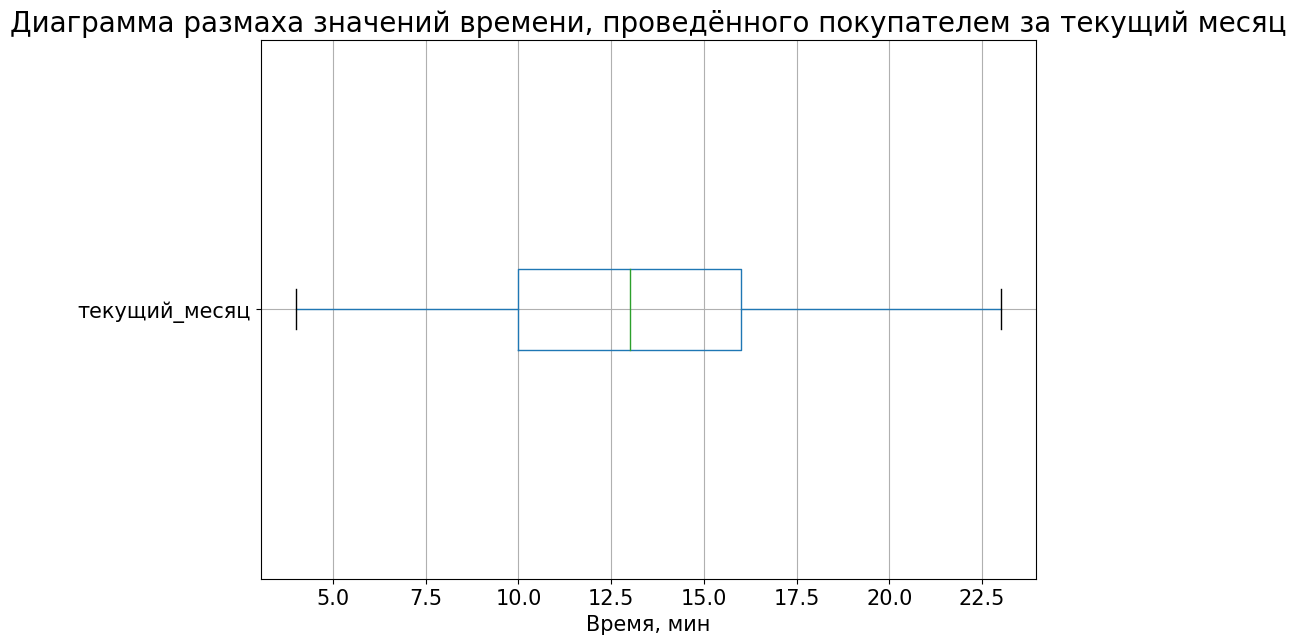

In [450]:
market_time.boxplot('текущий_месяц', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха значений времени, проведённого покупателем за текущий месяц', size=20)
plt.xlabel('Время, мин', size=15)
market_time['текущий_месяц'].describe()

По обоим месяцам очень похожее распределение проведённого покупателем времени на сайте. Минимальное значение - около 5, максимальное - 23, а в среднем 13 минут.

### Покупательская активность.

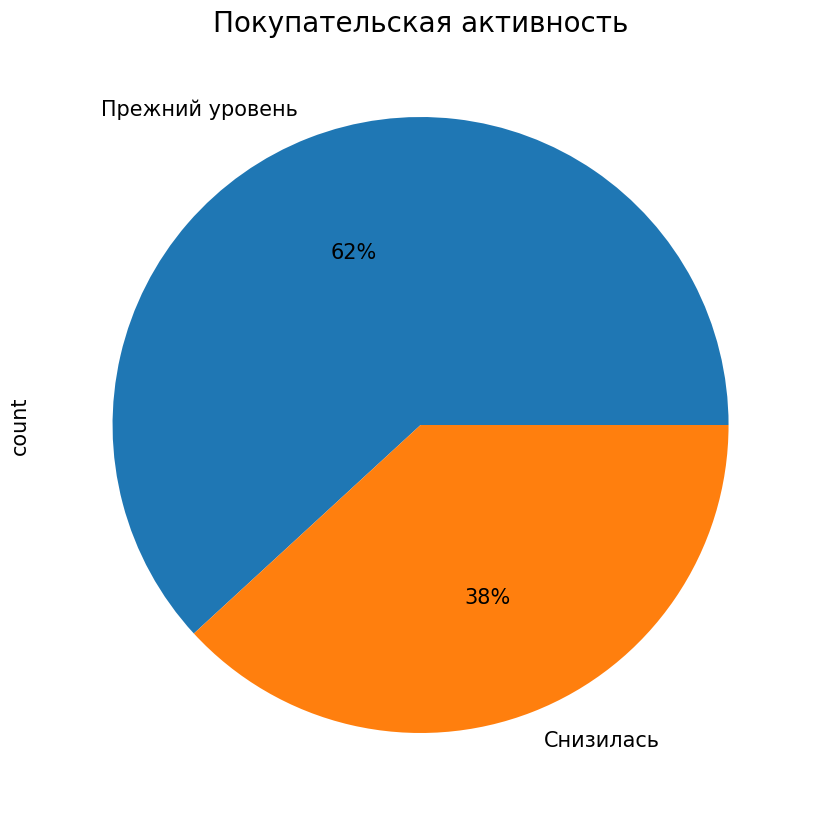

In [451]:
market_file['Покупательская_активность'].value_counts().plot(kind='pie', subplots=True, figsize=[15, 10], autopct='%.0f%%')
plt.title('Покупательская активность', size=20)
plt.rc('font', size= 15)
plt.show()

Ну и наконец, наш целевой признак. Покупательская активность снизилась у 38% покупателей. Есть небольшой дисбаланс классов, что нужно будет учесть при обучении модели. При разделении выборки на тренировочную и тестовую нужно будет учесть эту пропорцию с помощью дополнительного параметра stratify.

В целом во всех числовых признаках обнаружили всего 1 явный выброс по выручке. В категориальных признаках увидели самую популярную категорию "товаров для детей". Теперь соединим все входные и целевой признаки для дальнейшего корреляционного анализа и поиска лучшей модели.

## Объединение таблиц.

Объединим 3 первых датафрейма в один по столбцу id, который в файлах market_money и market_time выступает теперь в качестве индекса. Поэтому сделаем этот же столбец и в файле market_file индексом. Также немного изменим названия столбцов в market_money и market_time, чтобы они не совпадали.

In [452]:
market_file = market_file.set_index('id')
market_file.head() # Проверим результат

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


In [453]:
market_time.rename(columns = {'предыдущий_месяц': 'предыдущий_месяц_время',
                              'текущий_месяц': 'текущий_месяц_время'},
                  inplace=True)
market_money.rename(columns = {'препредыдущий_месяц': 'препредыдущий_месяц_выручка',
                               'предыдущий_месяц': 'предыдущий_месяц_выручка',
                               'текущий_месяц': 'текущий_месяц_выручка'}, 
                   inplace=True)
market_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   предыдущий_месяц_время  1297 non-null   int64
 1   текущий_месяц_время     1297 non-null   int64
dtypes: int64(2)
memory usage: 30.4 KB


In [454]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   предыдущий_месяц_выручка     1297 non-null   float64
 1   препредыдущий_месяц_выручка  1297 non-null   float64
 2   текущий_месяц_выручка        1297 non-null   float64
dtypes: float64(3)
memory usage: 72.8 KB


Как мы видим, всё прошло корректно. Количество строк везде совпадает, как и индексы.

А теперь уже можно непосредственно приступить к объединению датафреймов.

In [455]:
market_full_ = market_file.join(market_money, how='outer')
market_full = market_full_.join(market_time, how='outer')
market_full.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [456]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1297 non-null   object 
 1   Тип_сервиса                          1297 non-null   object 
 2   Разрешить_сообщать                   1297 non-null   object 
 3   Маркет_актив_6_мес                   1297 non-null   float64
 4   Маркет_актив_тек_мес                 1297 non-null   int64  
 5   Длительность                         1297 non-null   int64  
 6   Акционные_покупки                    1297 non-null   float64
 7   Популярная_категория                 1297 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  Ошибка_сервиса                       1297 non-null   int64  
 11  Страниц_за_визит            

Получили итоговоый датафрейм. Все столбцы заполненые без пропусков, а значит индексы (id) совпадали полностью. Теперь в нашем распоряжении все входные признаки для создания модели в одном датафрейме. Далее мы перейдём к корреляционному анализу этих признаков.

## Корреляционный анализ.

Построим матрицу корреляции для всех признаков общего датафрейма, чтобы посмотреть насколько сильна зависимость между ними (есть ли мультиколлинеарность?), а также насколько целевой признак зависим от входных.

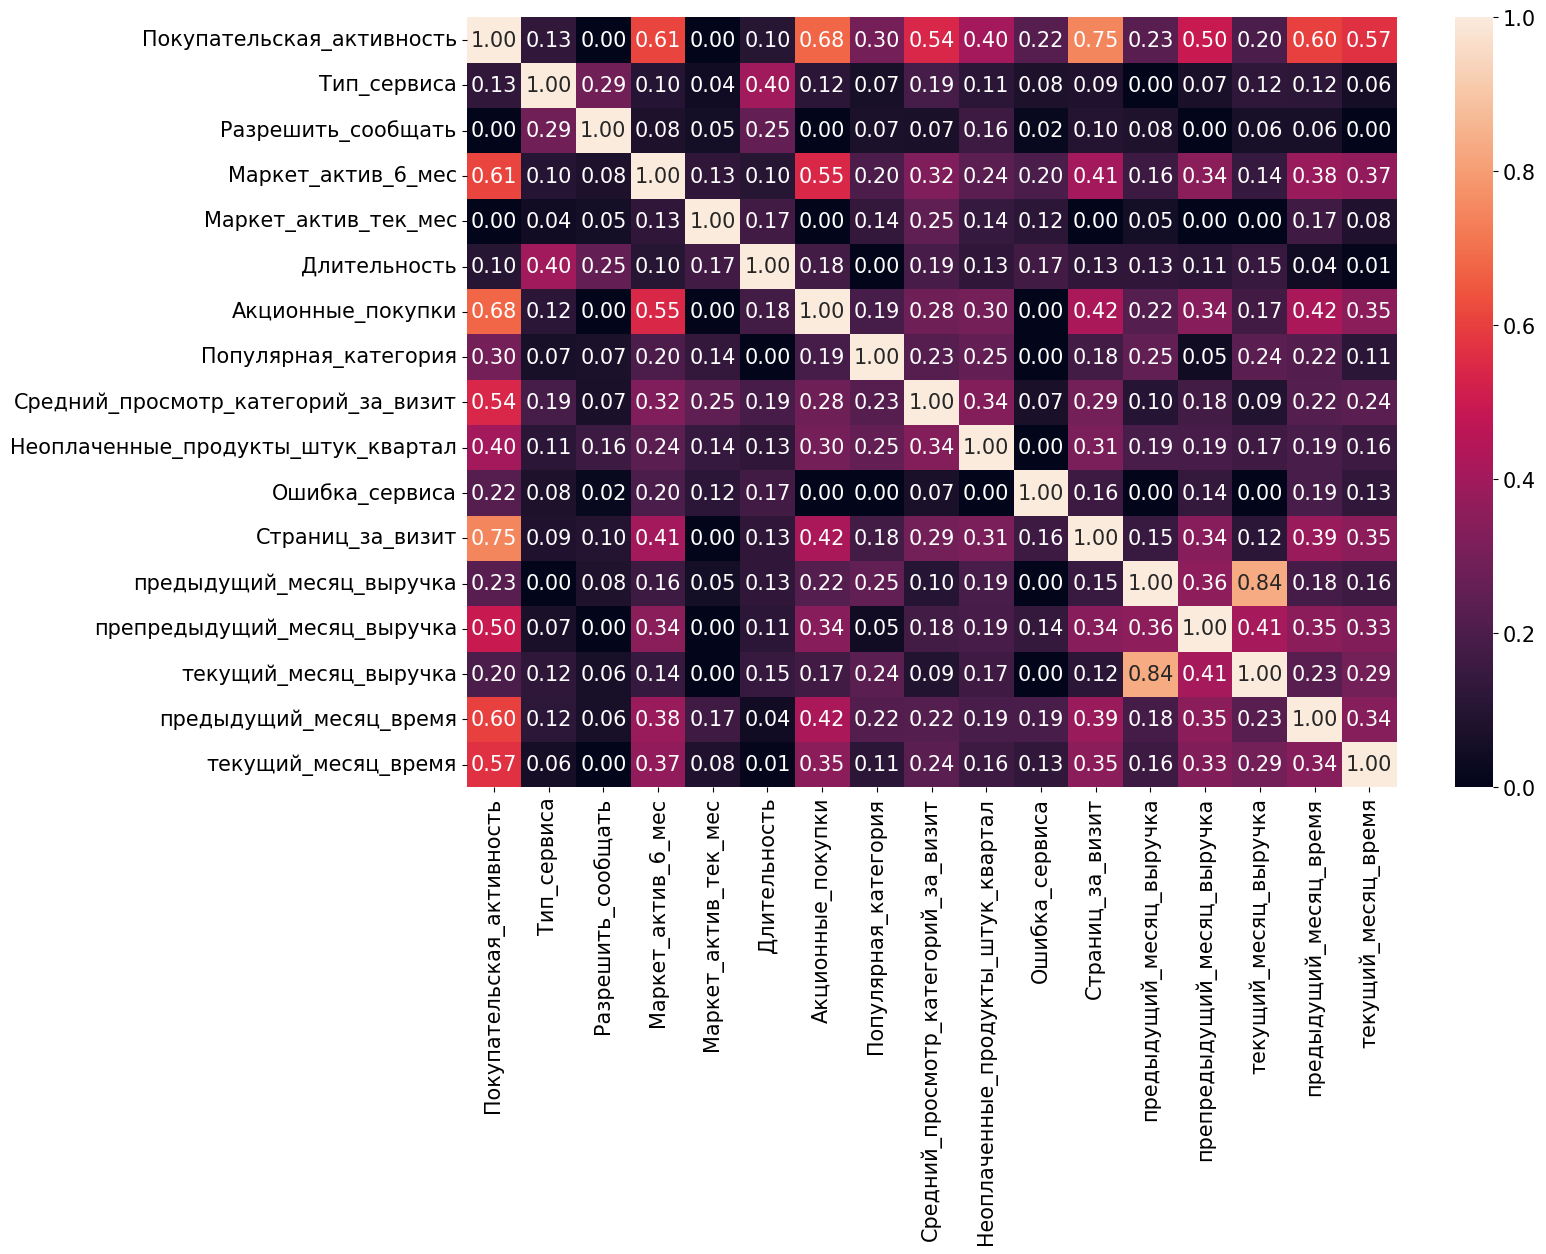

In [457]:
plt.figure(figsize=(15, 10))
sns.heatmap(market_full.phik_matrix(interval_cols = ['Длительность', 'Акционные покупки',
                                                     'Страниц за визит',
                                                     'предыдущий_месяц_выручка',
                                                     'препредыдущий_месяц_выручка',
                                                     'текущий_месяц_выручка']), annot=True, fmt='.2f')
plt.show()

По матрице корреляции мы не наблюдаем свойства мультиколлинеарности между входными признаками. Чтобы было какое то заметное негативное влияние на модель, надо, чтобы коэффициент между признаками был более 0.9, а у нас максимальное значение 0.84 между "предыдущий_месяц_выручка" и "текущий_месяц_выручка". Так что с этим всё в порядке. Ну и конечно нас интересует, какая зависимость между целевым признаком и входными. Это мы можем увидеть в самой верхней строчке матрицы или в самом левом столбце. Максимальный коэффициент с целевым показал признак "Страниц_за_визит", на втором месте - "Акционные_покупки", на третьем - "маркет_актив_6_мес", что в общем кажется логичным. Чем больше покупатель просматривает страниц и чем дольше он проводит время на сайте, тем скорее его покупательская активность как минимум не снизится. Связь процента акционных покупок с покупательской активностью тоже не вызывает возражений, как и эффект от маркетинга. Есть ещё 4 признакf с коэффициентами от 0.54 до 0.60, а остальные заметно ниже. Но конечно мы не можем делать каких то серьёзных выводов из этих зависимостей. Всё покажут результаты предсказания лучшей модели, которую мы будем искать на следующем этапе с помощью пайплайна. И уже на основе модели оценим важность признаков.

## Использование пайплайнов.

Для поиска лучшей модели мы будем использовать так называемый пайплайн. Это очень удобный инструмент для перебора моделей и их гиперпараметров. Без него нам понадобилось бы писать очень много кода и затратить огромное количество времени. Будем тестировать 4 модели: KNeighborsClassifier()(метод k-ближайших соседей), DecisionTreeClassifier()(дерево решений), LogisticRegression()(логистическая регрессия), SVC()(метод опорных векторов). Также для перебора вариантов моделей со всеми гиперпараметрами воспользуемся методом RandomizedSearch, который будет значительно быстрее при большом количестве гиперпараметров, чем, например, GridSearch. RandomizedSearchCV перебирает фиксированное случайное количество этих параметров, тем самым заметно ускоряя процесс. Для задачи бинарной классификации хорошо подойдёт метрика roc-auc, идеальное значение которой будет равно 1. Она не зависит от выбранного порога классификации, а также подходит к случаю, когда объектов с одним значением целевого признака больше, чем с другими (в нашем случае 62% на 38%).

In [458]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разбиваем выборку на тренировочную и тестовую, попутно разделяя входные и целевой признак
X_train, X_test, y_train, y_test = train_test_split(
    market_full.drop(
        [
            'Покупательская_активность',
        ], 
        axis=1
    ),
    market_full['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_full['Покупательская_активность']
)

# Закодируем целевой признак
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test) 

# создаём списки с названиями признаков для последующего кодирования и масштабирования
ohe_columns = ['Разрешить_сообщать', 'Популярная_категория', ]
ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес',
               'Маркет_актив_тек_мес',
               'Длительность',
               'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса',
               'Страниц_за_визит',
               'предыдущий_месяц_выручка',
               'препредыдущий_месяц_выручка',
               'текущий_месяц_выручка',
               'предыдущий_месяц_время',
               'текущий_месяц_время']

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [        
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ) 
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создайте итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_distributions = [
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    },
       # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear'],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    }
] 

# воспользуемся методом RandomizedSearch для перебора вариантов моделей,их гиперпараметров и скейлеров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5,
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# обучим модель на тренировочной выборке с помощью пайплайна
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

# рассчитаем метрику ROC-AUC и выведем с округлением до третьего знака
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred).round(3)}')

Лучшая модель и её параметры:

 {'preprocessor__num': RobustScaler(), 'models__C': 4, 'models': LogisticRegression(C=4, random_state=42)}
Метрика лучшей модели на кросс-валидации: 0.8974345121981486
Метрика ROC-AUC на тестовой выборке: 0.923


Лучший результат 0.8975 показала модель логистической регрессии LogisticRegression с гиперпараметром силы регуляризации C=1 (чем больше данный параметр, тем более сложные зависимости между признаками может находить модель, но как видим оптимальным получилось значение по умолчанию - 1) и со скейлером RobustScaler(метод, устойчивый к выбросам). Как мы увидели, с помощью пайплайнов можно автоматизировать множество операций машинного обучения: перебрать варианты масштабирования, модели и их гиперпараметры, чтобы выбрать лучшую комбинацию. На тестовой выборке результат метрики получился 0.923 - неплохой результат.

## Анализ важности признаков.

Чтобы лучше понять как работает выбранная модель с результатом, мы можем проанализировать важность всех входящих признаков для этой модели. Для этого выберем метод shap.  

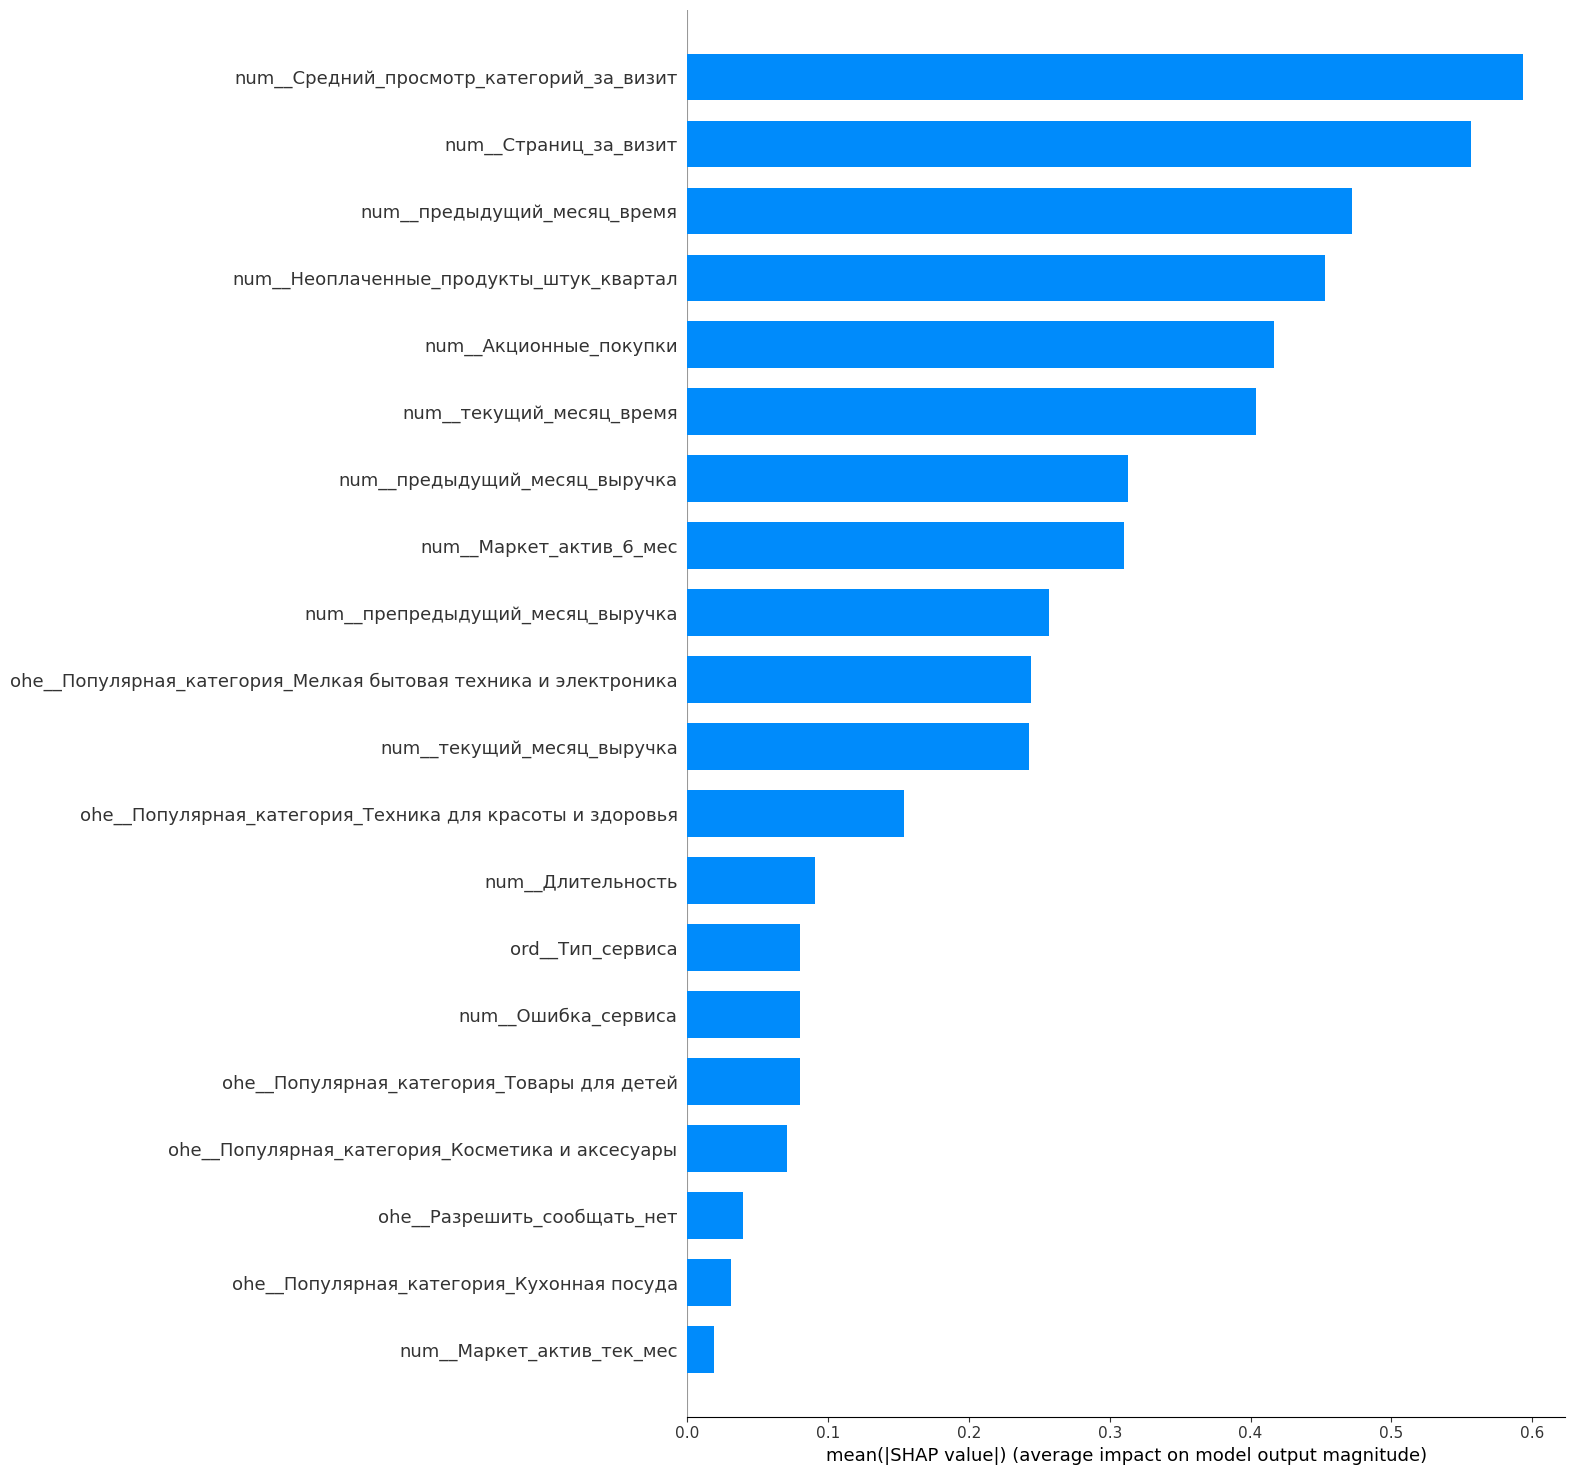

In [459]:
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
explainer = shap.LinearExplainer(
    randomized_search.best_estimator_.named_steps['models'],
    X_train_transformed,
    feature_names=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    )
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar", 
                  feature_names=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
                  plot_size=(16, 15))

Самым значимым признаком для модели оказался "Средний_просмотр_категорий_за_визит". А если мы посмотрим на первые 3 признака, то все они связаны с активностью покупателя на сайте: количество просмотренных категорий, страниц, время на сайте. Всё это логично выглядит: чем больше клиент проводит времени на сайте, просматривает больше разных разделов, тем больше покупательская активность. Вряд ли он будет проводить много времени в интернет-магазине при этом не совершая никаких покупок. Также важны признаки количества неоплаченных продуктов в корзине и маркетинговой активности за 6 месяцев (тогда как маркетинговая активность в текущем месяце почти не имеет влияния).  Если говорить о категориальных признаках, то их влияние очень низкое, по сути ими можно даже пренебречь. Самое большой вклад на модель из них имеет "популярная_категория_Мелкая бытовая техника и электроника". На данном графике мы видим только важность признаков, но вот как именно он влияет на результат предсказания, мы можем сказать проанализировав следующий график.

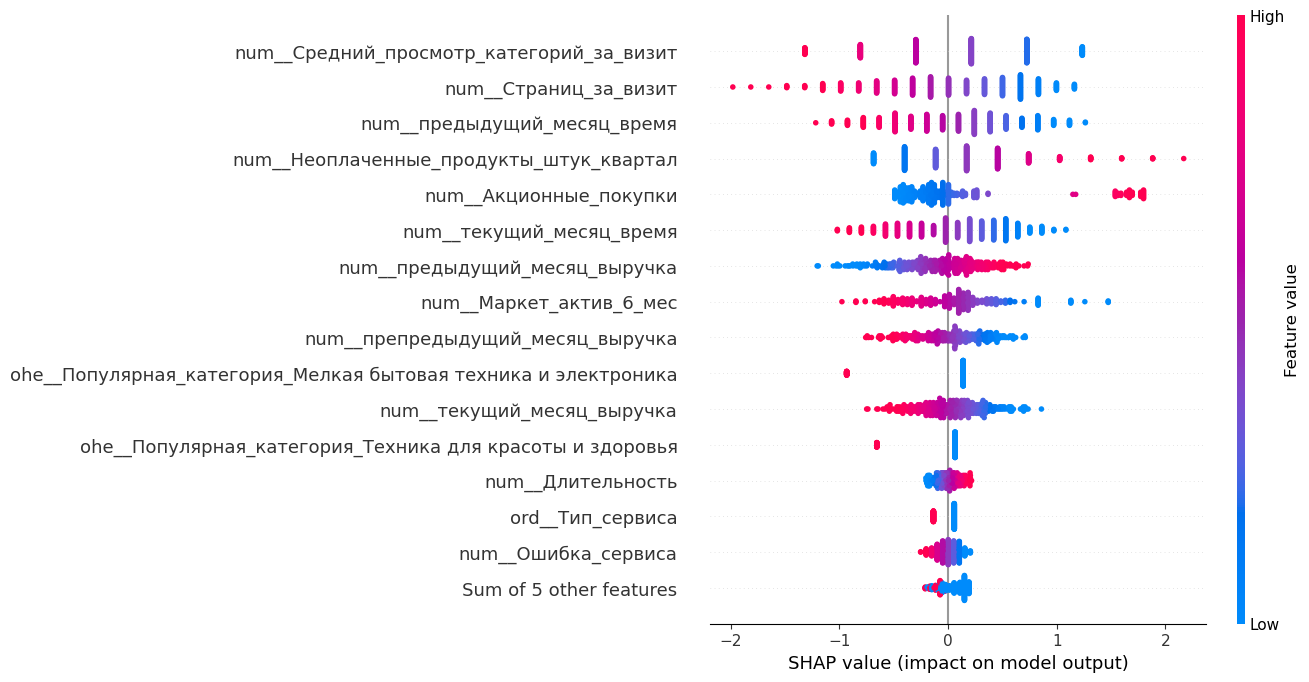

In [460]:
plt.figure(figsize=(20, 15))
shap.plots.beeswarm(shap_values, max_display=16)

Здесь по первым трём признакам подтверждается наш вывод о том, что большие их значения (красный цвет) склоняют модель к результату 0 класса (активность осталась на прежнем уровне), а малые (синий цвет) -  с точностью до наоборот. Большое количество неоплаченных продуктов в корзине, как мы и рассуждали выше, побудит модель предсказать класс 1 (активность снизилась). Такой же эффект даст и значительное количество акционных покупок у клиента (значит без специальных предложений такие клиенты скорее всего будут соврешать совсем мало приобретений). Интересный момент с выручкой по месяцам (хотя она далеко не на первом месте по важности). Если высокие значения выручки текущего и предпредыдущего месяца означают, что модель покажет, что клиент сохранит текующую активность, а вот при таких же данных за предыдущий месяц - предскажет снижение активности. В общем то в этом есть логика. Вполне возможно, что клиенты, совершив много покупок в каком то месяце, в следующем купят или значительно меньше, или вообще обойдутся без покупок. Вполне логичным выглядит и то, что большая маркетинговая активность за 6 месяцев повышает шансы на то, что клиент не снизит уровень покупок. Наличие у покупателя любимой категории, связанной с техникой скорее склонит модель к тому, что покупательская активность останется на прежнем уровне. Но влияние этих признаков, судя по предыдущему графику очень малое.

## Сегментация покупателей.

На данном этапе выберем группу покупателей, по которой можно сделать предложение по повышению покупательской активности. Логичным будет выбрать категорию клиентов, которая приносить большую прибыль, но в то же время по ней большая вероятность снижения покупательской активности согласно данным моделирования. Возьмём данный из тестовой выборки и добавим вероятности отнесения к классу 1 ("Снизилась").

In [461]:
prob_of_decrease = pd.DataFrame({'id': X_test.index, 'Вероятность_снижения': randomized_search.predict_proba(X_test)[:, 1]})
prob_of_decrease

,id,Вероятность_снижения
0,216446,0.443295
1,215469,0.768314
2,216301,0.047870
3,215713,0.783642
4,215500,0.955154
...,...,...
320,215568,0.636444
321,216119,0.131437
322,215504,0.987506
323,216547,0.593435


Затем добавим к получившемуся датафрейму данные по прибыли от клиентов.

In [462]:
prob_of_decrease_money = prob_of_decrease.merge(money, on='id', how='left' ).set_index('id')
prob_of_decrease_money

,Вероятность_снижения,Прибыль
id,,
216446,0.443295,4.47
215469,0.768314,3.76
216301,0.047870,4.34
215713,0.783642,4.42
215500,0.955154,4.99
...,...,...
215568,0.636444,5.49
216119,0.131437,4.93
215504,0.987506,2.08


In [463]:
prob_of_decrease_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325 entries, 216446 to 215398
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Вероятность_снижения  325 non-null    float64
 1   Прибыль               325 non-null    float64
dtypes: float64(2)
memory usage: 7.6 KB


Всё прошло корректно, пропусков нет. А теперь построим график "Вероятность снижения покупательской активности / Прибыль".

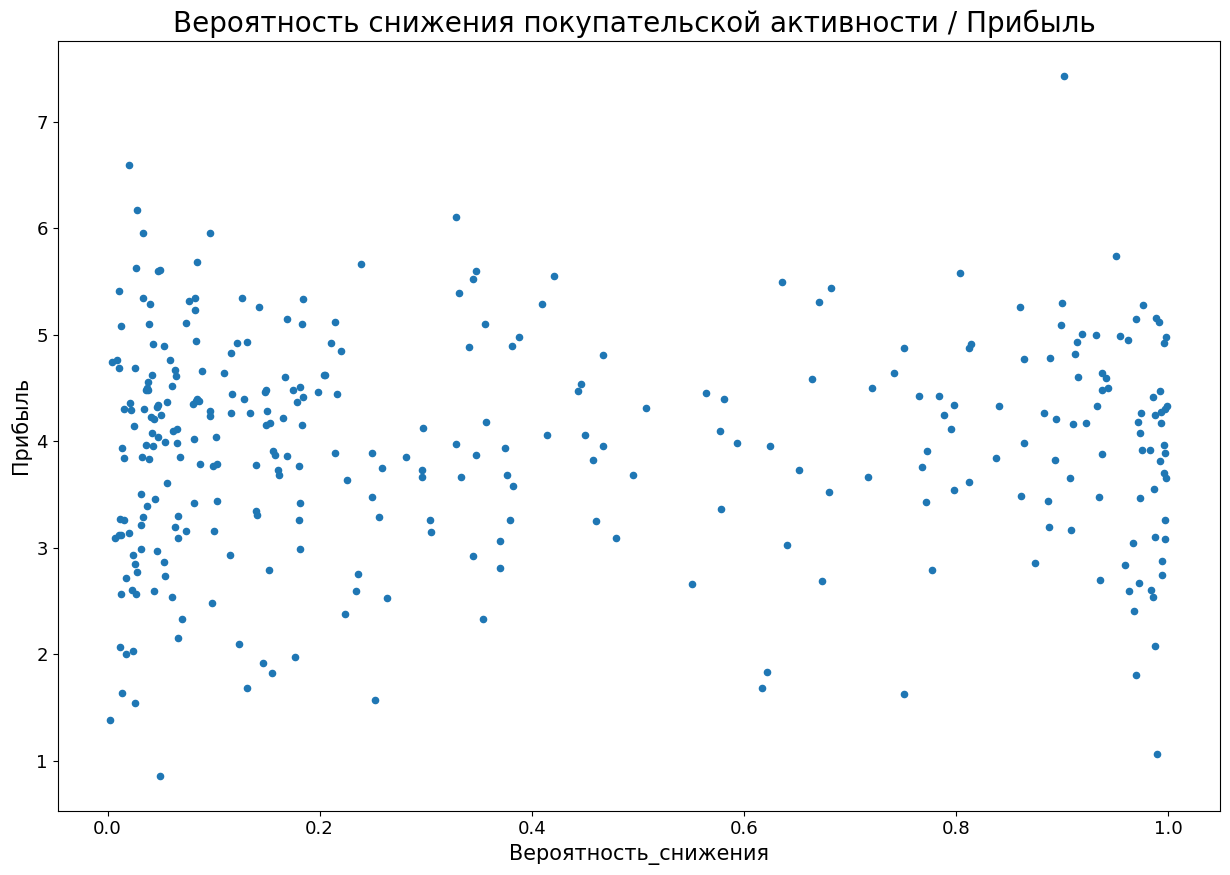

In [464]:
prob_of_decrease_money.plot(kind='scatter', x='Вероятность_снижения', y='Прибыль', figsize=(15, 10))
plt.title('Вероятность снижения покупательской активности / Прибыль ', size=20)
plt.xlabel('Вероятность_снижения', size=15)
plt.ylabel('Прибыль', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

Интересный нам сегмент покупателей находится в верхнем правом квадрате этого графика, то есть с большой вероятностью снижения покупательской активности (более 0.5) и большой прибылью (более 3). Отфильтруем датафрейм и оставим в нём только покупателей данной категории.

In [465]:
high_money = prob_of_decrease_money[(prob_of_decrease_money['Вероятность_снижения']>0.5)&(prob_of_decrease_money['Прибыль']>3)]
high_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 215469 to 215398
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Вероятность_снижения  94 non-null     float64
 1   Прибыль               94 non-null     float64
dtypes: float64(2)
memory usage: 2.2 KB


Число таких покупателей 94.

In [466]:
high_money_full = high_money.join(market_full, how='left')
high_money_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 215469 to 215398
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Вероятность_снижения                 94 non-null     float64
 1   Прибыль                              94 non-null     float64
 2   Покупательская_активность            94 non-null     object 
 3   Тип_сервиса                          94 non-null     object 
 4   Разрешить_сообщать                   94 non-null     object 
 5   Маркет_актив_6_мес                   94 non-null     float64
 6   Маркет_актив_тек_мес                 94 non-null     int64  
 7   Длительность                         94 non-null     int64  
 8   Акционные_покупки                    94 non-null     float64
 9   Популярная_категория                 94 non-null     object 
 10  Средний_просмотр_категорий_за_визит  94 non-null     int64  
 11  Неоплаченные_продукты_штук_ква

In [467]:
high_money_full.head()

,Вероятность_снижения,Прибыль,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,,,
215469,0.768314,3.76,Снизилась,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8
215713,0.783642,4.42,Снизилась,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14
215500,0.955154,4.99,Снизилась,стандарт,да,3.5,4,573,0.40,Косметика и аксесуары,2,4,1,4,4137.0,4278.0,3808.1,11,12
215356,0.914486,4.93,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215642,0.935167,3.48,Снизилась,премиум,да,3.8,4,962,0.30,Косметика и аксесуары,2,2,2,5,4857.0,4419.0,5455.0,7,7


Давайте теперь исследуем этот сегмент покупателей поподробней. 

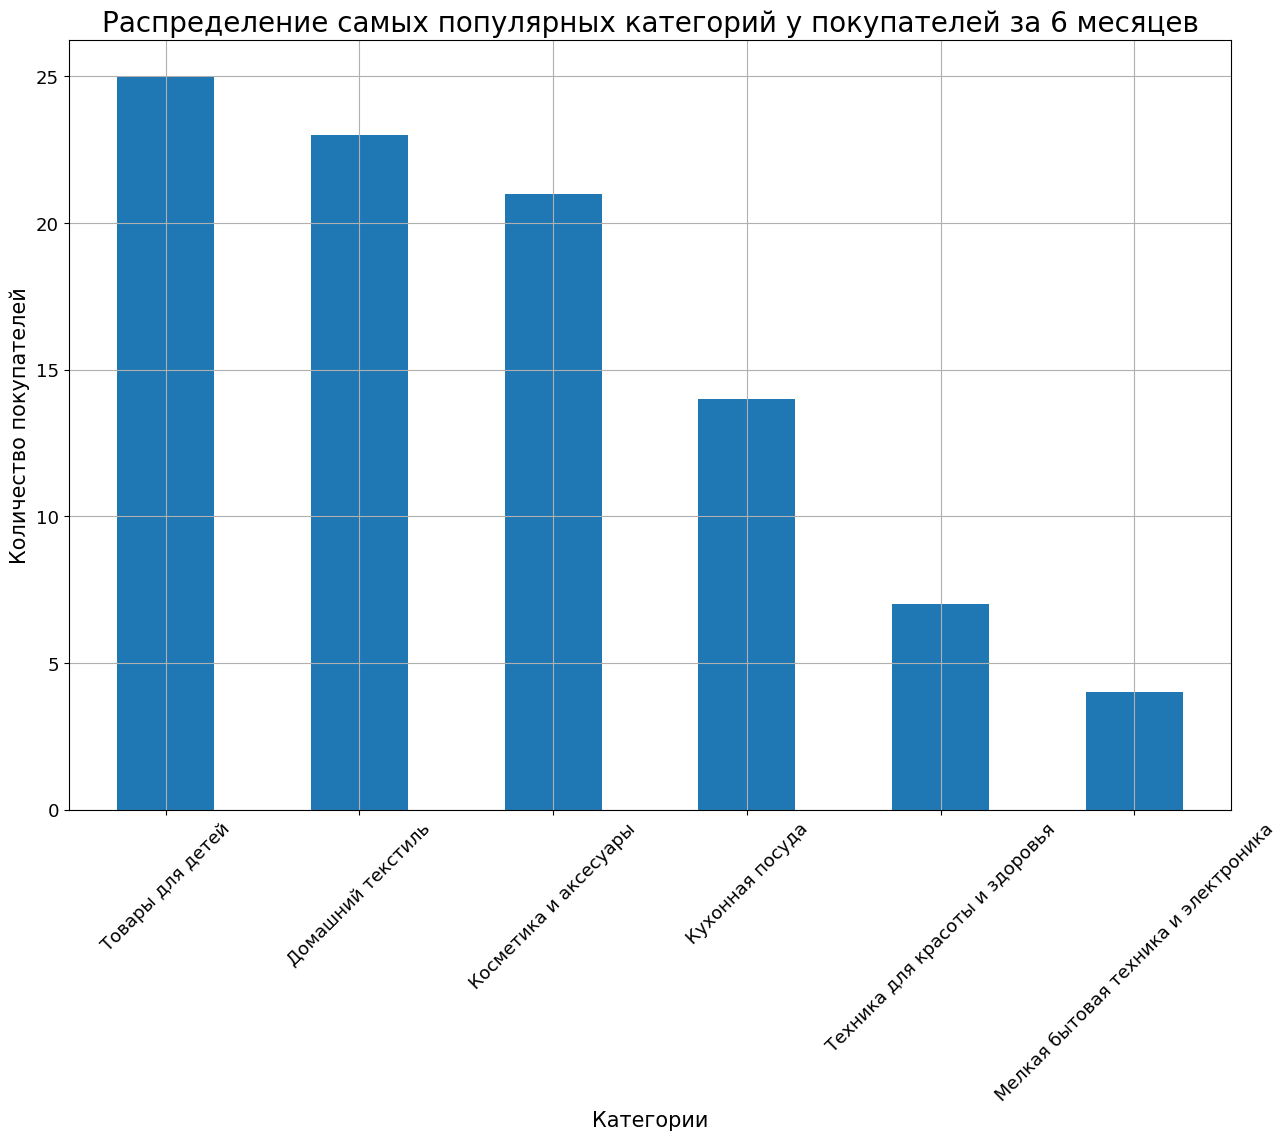

In [468]:
high_money_full['Популярная_категория'].value_counts().plot(kind='bar', figsize=(15, 10))
plt.title('Распределение самых популярных категорий у покупателей за 6 месяцев', size=20)
plt.xlabel('Категории', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13, rotation=45)
plt.yticks(size = 13)
plt.grid()
plt.show()

Рейтинг популярных категорий данного сегмента клиентов в целом повторяет рейтинг общей выборки за исключением того, что кухонная посуда с последнего места перешла на 4-е место. Логичным является то, что различная техника располагается на последних местах, так как она покупается на долгий срок. Поэтому имеет смысл провести акции именно с самыми популярными категориями товаров, которые в принципе покупаются чаще (товары для детей, домашний текстиль, косметика и аксессуары). Имея хорошее предложение, данный покупатель предпочтёт именно этот интернет-магазин другому, тем более, что он уже принёс хорошую прибыль ранее. Это конечно не значит, что на технику вообще не надо проводить акций. Просто делать их можно реже.

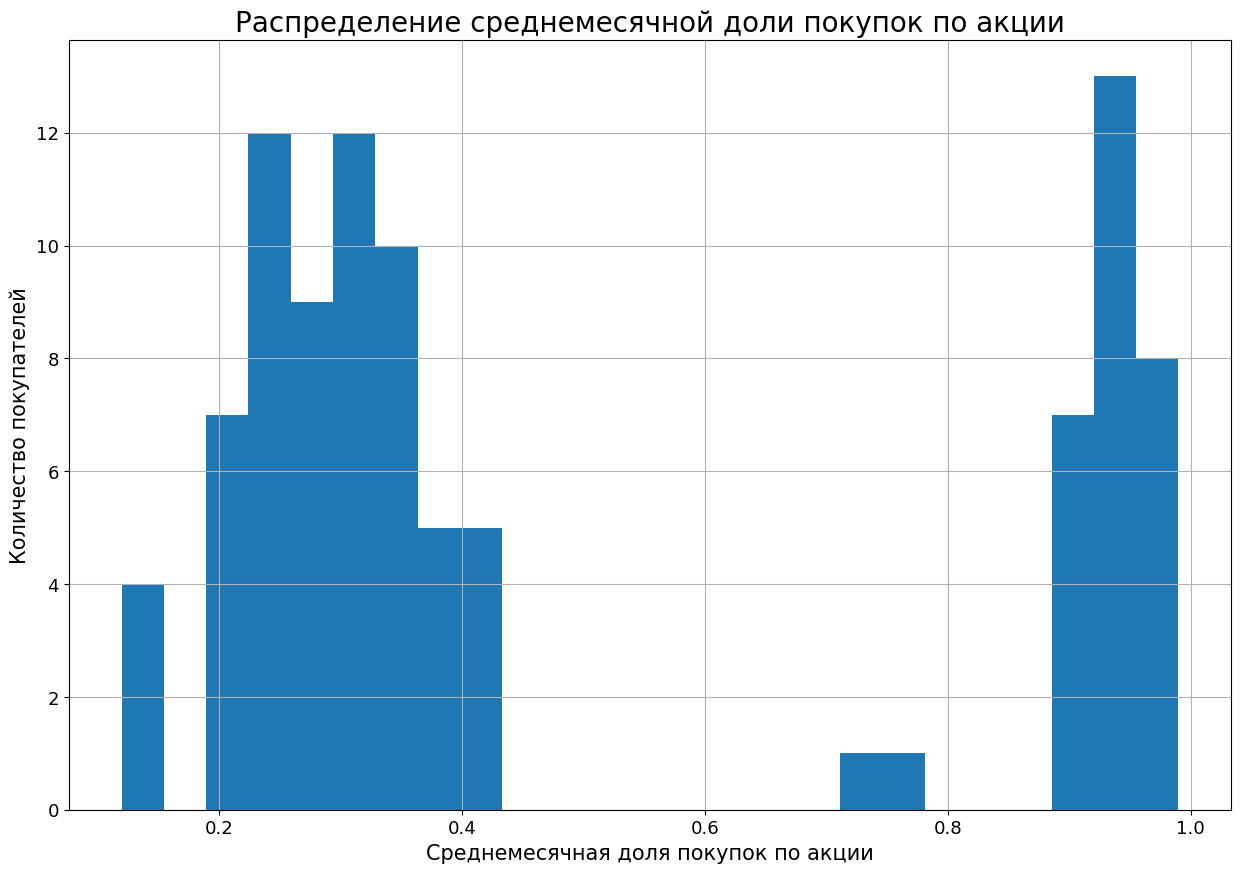

In [469]:
high_money_full['Акционные_покупки'].hist(bins=25, figsize=(15, 10))
plt.title('Распределение среднемесячной доли покупок по акции', size=20)
plt.xlabel('Среднемесячная доля покупок по акции', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

In [470]:
high_money_full_action = high_money_full[high_money_full['Акционные_покупки']>0.7]
len(high_money_full_action)

30

Мы видим, что у 30 покупателей из 94 (то есть у трети), приносящих большую прибыль, акционные покупки составляют более 70% от общего числа. Поэтому акции очень важны и нужны, особенно для данной подкатегории клиентов. Кстати, посмотрим, какие категории выбирали эти 30 покупателей.

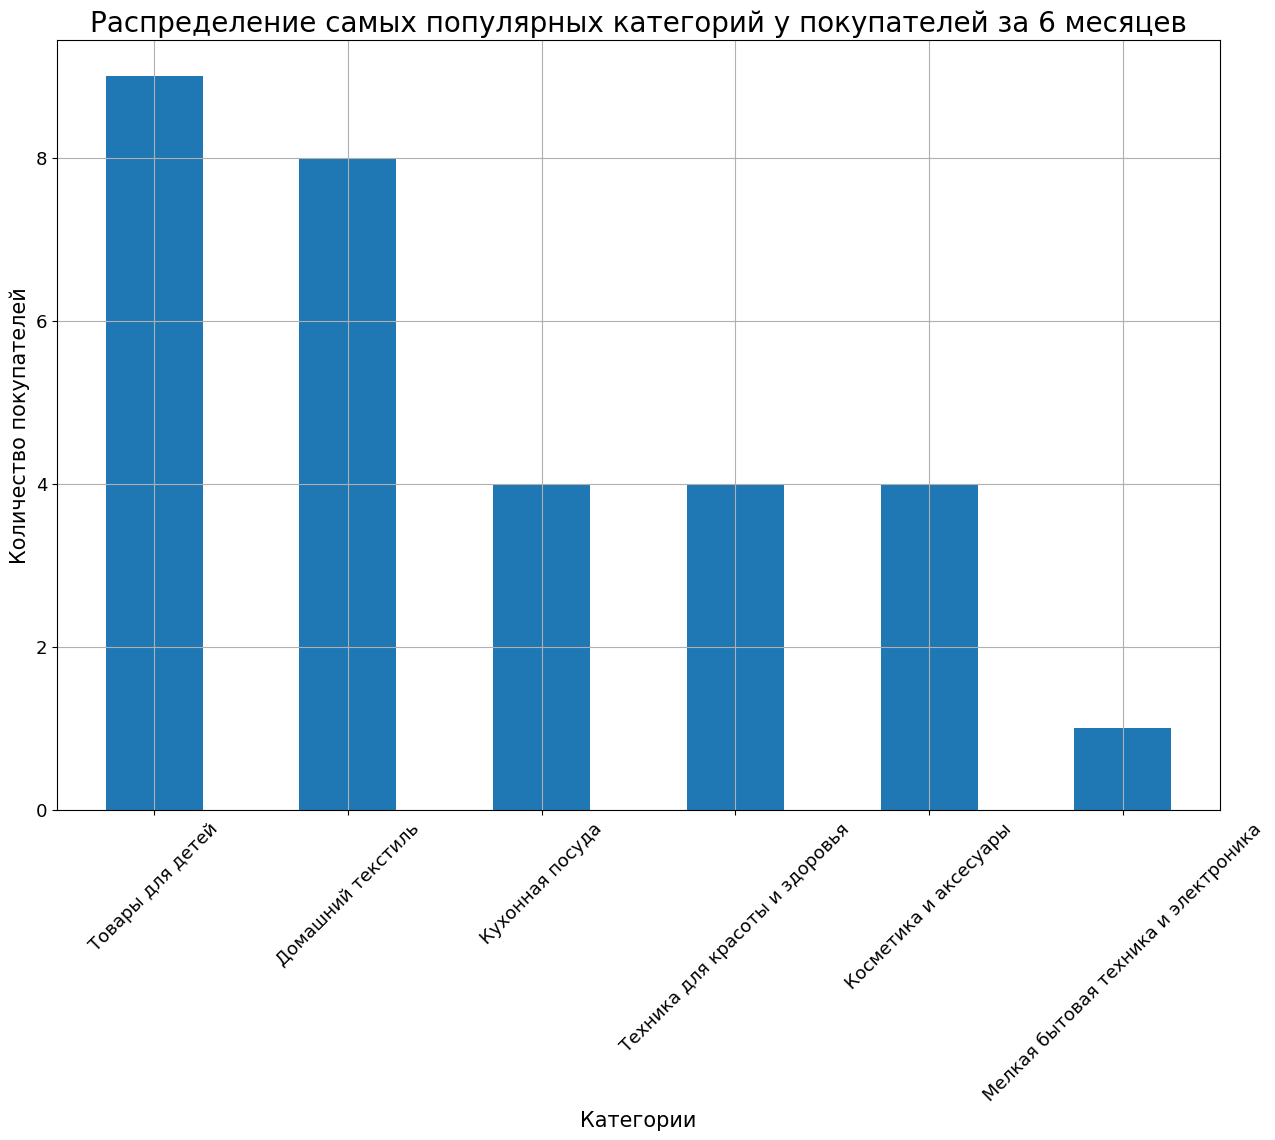

In [471]:
high_money_full_action['Популярная_категория'].value_counts().plot(kind='bar', figsize=(15, 10))
plt.title('Распределение самых популярных категорий у покупателей за 6 месяцев', size=20)
plt.xlabel('Категории', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13, rotation=45)
plt.yticks(size = 13)
plt.grid()
plt.show()

В общем то всё те же ведущие категории.

Давайте посмотрим, есть ли какая то динамика трат по категориям между предпредыдущим месяцем и текущим. Для этого создадим дополнительный столбец с разницей выручки между этими месяцами, а потом посмотрим на распределение этой разницы на диаграммах размаха по каждой категории.

In [472]:
high_money_full['разница_в_выручке'] = high_money_full['текущий_месяц_выручка'] - high_money_full['препредыдущий_месяц_выручка']

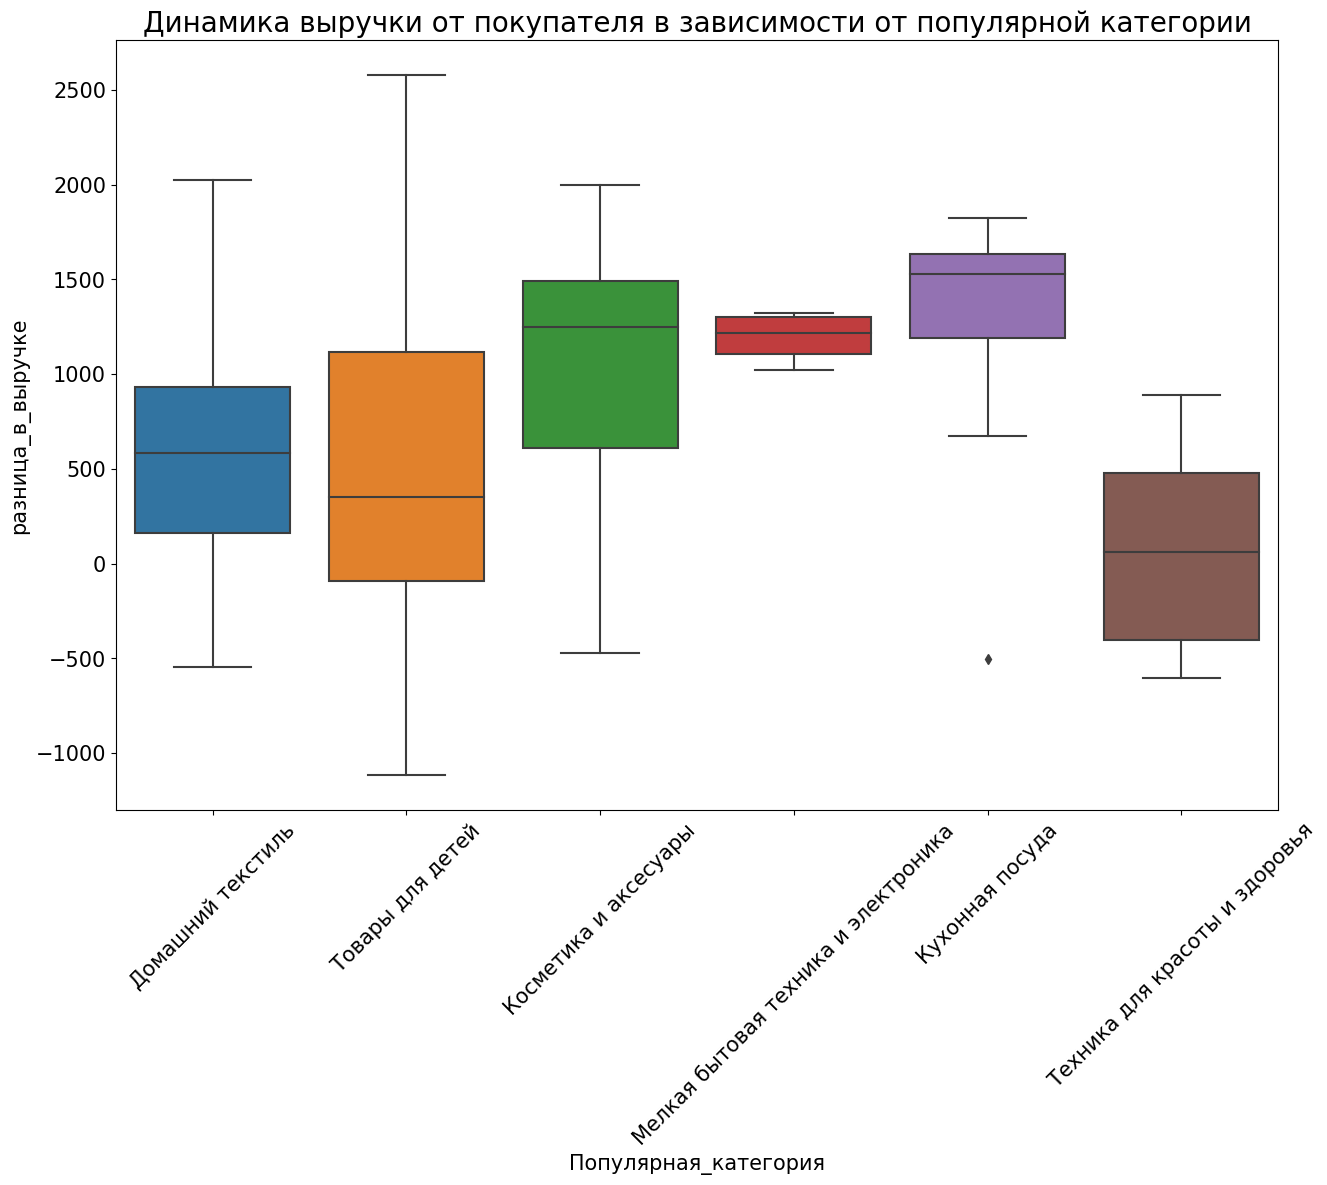

In [473]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=high_money_full, x='Популярная_категория', y='разница_в_выручке')
plt.title('Динамика выручки от покупателя в зависимости от популярной категории', size=20)
plt.xticks(rotation=45)
plt.show()

Как можно заметить, динамика в основном везде положительная. Но есть небольшое проседание по категории "Техника для красоты и здоровья". Можно было бы подтянуть эту категорию специальными акциями для этих клиентов. Хотя, как мы отмечали и выше, техника покупается на долгий срок, и такое понижение выглядит логично. Но, например, разброс значений разницы в выручке для мелкой бытовой техники и электроники очень маленький и строго положительный, то есть прирост на лицо. В рассматриваемой выборке мы имеем данные о выручке всего за 3 месяца и конечно сделать какие то высокоточные выводы о динамике сложновато. 

Тем не менее, кажется логичным провести акции в первую очередь по самым популярным категориям (домашний текстиль, товары для детей, косметика). Тем более, что они же являются самыми популярными для клиентов, совершивших более 70% покупок от общего числа по акции. Само собой, категории с техникой и кухонной посудой тоже нуждаются в периодическом продвижении (несмотря на их долгий срок службы), иначе есть риск того, что клиенты приобретут данные товары в другом месте, когда подойдёт время.

## Общий вывод.

    Итак, перед нами стояла задача разработать решение, которое позволит сделать специальное предложение постоянным клиентам, чтобы сохранить их покупательскую активность. 
    В исходных данных у нас было 4 датафрейма. Основной - с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Также файл с данными о помесячной выручке от клиента, времени проведённом на сайте помесячно и данные о среднемесячной прибыли за 3 месяца от каждого.
    Данные в целом были в хорошем состоянии, поэтому предобработка не заняла много времени. Немного подправили названия столбцов, убрали неявные дубликаты в Типах сервиса, исправили тип данных в датасете с прибылью и убрали небольшую опечатку.
    Далее мы исследовали все признаки по очереди. Стоит отметить на этом этапе только один выброс по выручке и обнаружение небольшого дисбаланса целевого признака, что имеет значение при моделировании.
    Для поиска лучшей модели мы применили очень удобный инструмент - пайплайн. С помощью определённых методов он перебирает все необходимые вам варианты масштабирования, моделей и их гиперпараметров и выдаёт лучший из всех вариант по заданной метрике (в данном случае мы применили 'roc-auc', которая хорошо подходит для бинарной классификации). В данном случае мы использовали все входные признаки (хотя иногда их отсеивают еще до создания модели). Свойств мультиколлинеарности между признаками мы не обнаружили. Таким вот образом мы получили лучший вариант модели: логистическая регрессия с гиперпараметром силы регуляризации C=1 и скейлером RobustScaler(). В точности такие параметры необходимо использовать для предсказаний покупательской активности клиентов интернет-магазина "В один клик". Также мы провели анализ важности признаков для модели. Выяснилось, что все категориальные признаки имеют незначительное влияние на модель (может чуть заметным было влияние наличия любимой категории "мелкая бытовая техника и электроника"), а вот среди числовых признаков очень большое значение имели признаки, касающиеся активности покупателя на сайте(время, кол-во категорий и т.д.), а также процент акционных покупок и количество неоплаченных товаров в корзине. Выручка имела заметно меньшее влияние.
    И наконец, для сегмента покупателей, принесших самую большую прибыль, но с высоким риском снижения активности, мы решили в первую очередь рекомендовать провести акции и сделать специальные предложения по самым популярным категориям (товары для детей, текстиль, косметика), по которым в принципе делается большинство покупок в магазине. Тем самым мы поддержим покупательскую активность этих очень важных клиентов. Тем более, что и среди них треть имеет процент покупок по акции более 70%.
    

Ссылка на репозиторий GitHub: https://github.com/Andrews83/Learning